In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=2, color_codes=True, rc=None)

import os, gc
os.listdir('DataSet/')

['Train.csv', 'Sample_submission.csv', 'Test.csv']

In [2]:
train = pd.read_csv("DataSet/Train.csv")
test  = pd.read_csv("DataSet/Test.csv")

train.shape, test.shape

((17521, 2395), (20442, 2394))

In [3]:
train['Col754']  = train['Col754'].replace('-',0).astype('float')
train['Col843']  = train['Col843'].replace('-',0).astype('float')

test['Col754']  = test['Col754'].replace('-',0).astype('float')
test['Col843']  = test['Col843'].replace('-',0).astype('float')


train.drop(['Col747','Col836'], axis=1, inplace=True)
test.drop(['Col747','Col836'], axis=1, inplace=True)


In [4]:
train.select_dtypes("object").isnull().sum()

Col1    0
dtype: int64

In [5]:
# for col in ['Col747','Col836']:
#     if col in no_imp_cat1:
#         print("found")

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report as cr
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


In [6]:
def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    test_pred  = clf.predict_proba(X_test[features])[:,1]

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 3.8,#1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.63,#0.09,
        'thread_count'          : 4,
        'l2_leaf_reg'           : 3.076,
    }
#     {'depth': 7.0,
#      'l2_leaf_reg': 3.0753960899722625,
#      'learning_rate': 0.063,
#      'random_strength': 3.8000000000000003}

    ##########################
    n_splits = 6
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
        score = f1_score(y_valid, y_bin, average='weighted')
        print( "  f1 = ", score )
        print("="*60)
        gc.collect()
        
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions


In [7]:
# train = train.astype('category')
target = train['Col2']
tr_ids = train['Col1']
ts_ids = test['Col1']
train.drop(['Col1','Col2'], axis=1, inplace=True)
test.drop('Col1', axis=1, inplace=True)

In [9]:
# clf_xgb1, imp_xgb1, oof_xgb1, predi_xgb1 = run_cv_xgb(train, target, test, depth=4)


In [8]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train, target, test, depth=4)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))


(14600,) (2921,)
Fold 0
0:	test: 0.5106024	test1: 0.5075207	best: 0.5075207 (0)	total: 246ms	remaining: 40m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7338937097
bestIteration = 69

Shrink model to first 70 iterations.
  auc =  0.7338937097488406
  f1 =  0.8691860738811253
(14600,) (2921,)
Fold 1
0:	test: 0.5170385	test1: 0.4982734	best: 0.4982734 (0)	total: 151ms	remaining: 25m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7060056607
bestIteration = 39

Shrink model to first 40 iterations.
  auc =  0.706005660734031
  f1 =  0.8582677165354329
(14600,) (2921,)
Fold 2
0:	test: 0.5105073	test1: 0.5265719	best: 0.5265719 (0)	total: 149ms	remaining: 24m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7197742439
bestIteration = 48

Shrink model to first 49 iterations.
  auc =  0.7197742439191132
  f1 =  0.8445817461963174
(14601,) (2920,)
Fold 3
0:	test: 0.5572929	test1: 0.5684783	best: 0.5684783 (0)	total: 221ms

NameError: name 'cr' is not defined

In [9]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     15760
           1       0.28      0.28      0.28      1761

   micro avg       0.86      0.86      0.86     17521
   macro avg       0.60      0.60      0.60     17521
weighted avg       0.86      0.86      0.86     17521



In [9]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train, target, test, depth=4)


(13140,) (4381,)
Fold 0
0:	test: 0.5463511	test1: 0.5591742	best: 0.5591742 (0)	total: 245ms	remaining: 40m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7263542134
bestIteration = 47

Shrink model to first 48 iterations.
  auc =  0.72635421342818
  f1 =  0.8689465511847237
(13141,) (4380,)
Fold 1
0:	test: 0.5596286	test1: 0.5705864	best: 0.5705864 (0)	total: 200ms	remaining: 33m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7273252192
bestIteration = 27

Shrink model to first 28 iterations.
  auc =  0.7273252191970465
  f1 =  0.8587613091457661
(13141,) (4380,)
Fold 2
0:	test: 0.5606766	test1: 0.5444829	best: 0.5444829 (0)	total: 175ms	remaining: 29m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7222790725
bestIteration = 20

Shrink model to first 21 iterations.
  auc =  0.7222790724503925
  f1 =  0.8602574658471008
(13141,) (4380,)
Fold 3
0:	test: 0.5870955	test1: 0.5543462	best: 0.5543462 (0)	total: 158ms	r

In [10]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))


              precision    recall  f1-score   support

           0       0.92      0.93      0.92     15760
           1       0.30      0.28      0.29      1761

   micro avg       0.86      0.86      0.86     17521
   macro avg       0.61      0.61      0.61     17521
weighted avg       0.86      0.86      0.86     17521



In [21]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train, target, test, depth=4)


(13140,) (4381,)
Fold 0
0:	test: 0.6242787	test1: 0.6317305	best: 0.6317305 (0)	total: 173ms	remaining: 28m 48s
200:	test: 0.8130972	test1: 0.7473342	best: 0.7483488 (197)	total: 36.2s	remaining: 29m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7484587405
bestIteration = 236

Shrink model to first 237 iterations.
  auc =  0.7484587405182038
  f1 =  0.8759475137761277
(13141,) (4380,)
Fold 1
0:	test: 0.6337724	test1: 0.6438256	best: 0.6438256 (0)	total: 258ms	remaining: 42m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7444148016
bestIteration = 118

Shrink model to first 119 iterations.
  auc =  0.7444148015689894
  f1 =  0.8681517469662217
(13141,) (4380,)
Fold 2
0:	test: 0.6277706	test1: 0.6423916	best: 0.6423916 (0)	total: 248ms	remaining: 41m 21s
200:	test: 0.8076206	test1: 0.7371810	best: 0.7376696 (193)	total: 37s	remaining: 30m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7376695893
bestIteration = 19

In [22]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.26      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.62     17521
weighted avg       0.86      0.88      0.87     17521

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.26      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.62     17521
weighted avg       0.86      0.88      0.87     17521



In [12]:
imp_cols = imp_cat2.tail(448)['feature'].values
null_cols = imp_cat2.tail(1000)['feature'].values[:-450]

imp_cols = list(reversed(imp_cols))
null_cols = list(reversed(null_cols))

In [26]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var[:10]:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    i = 0   
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var[10:20]:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        
    plt.show()
        
    i = 0
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var[20:30]:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        
    plt.show()
    
    i = 0
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var[30:40]:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="cls: 1")
        sns.kdeplot(t0[feature], bw=0.5,label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.show()    
        
    i = 0
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var[40:50]:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        
        
    plt.show()

<Figure size 432x288 with 0 Axes>

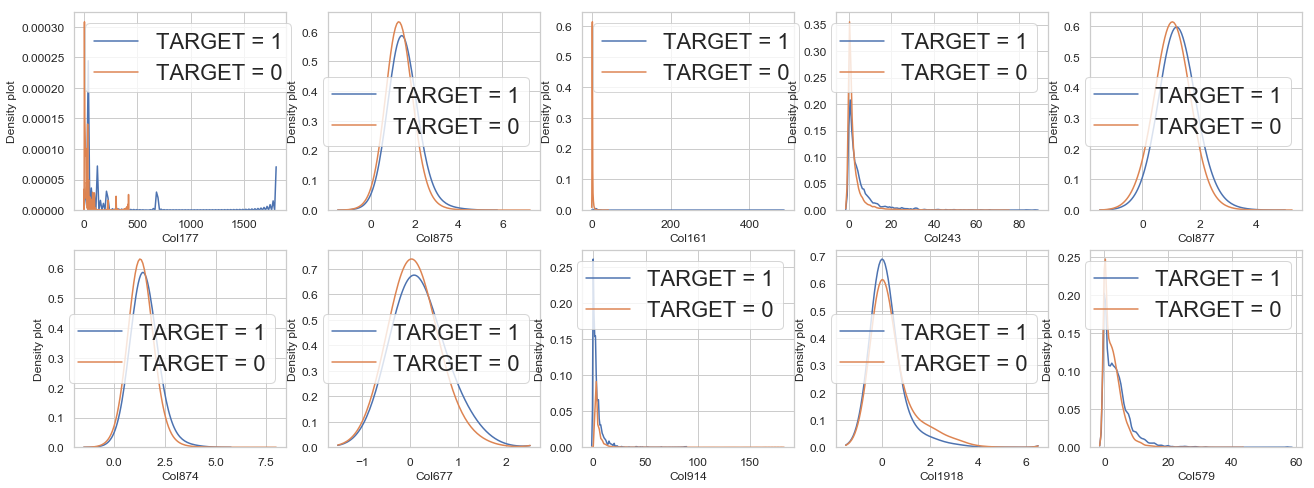

<Figure size 432x288 with 0 Axes>

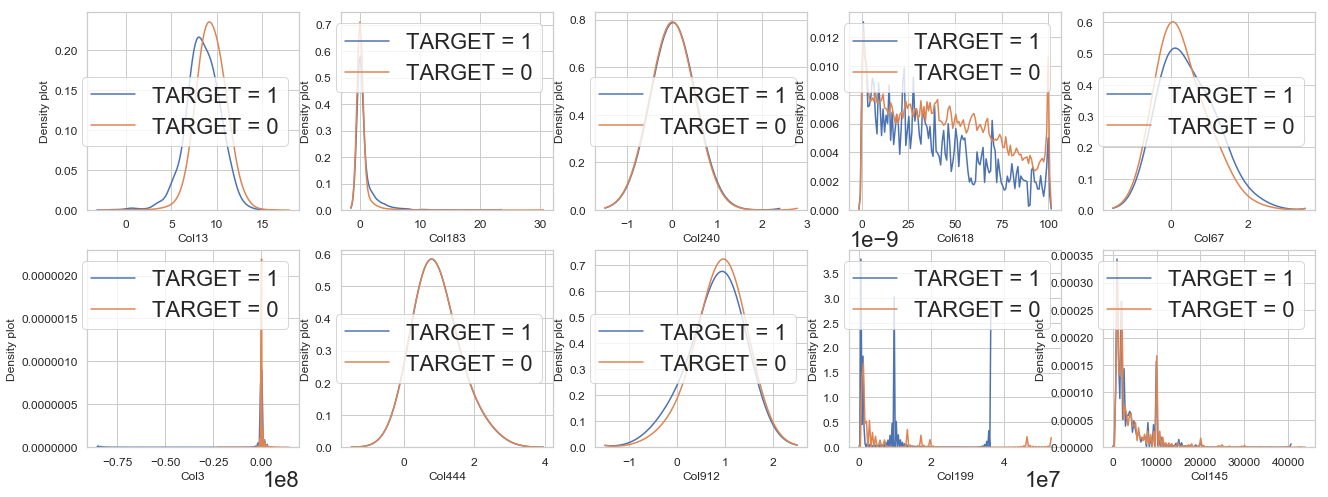

<Figure size 432x288 with 0 Axes>

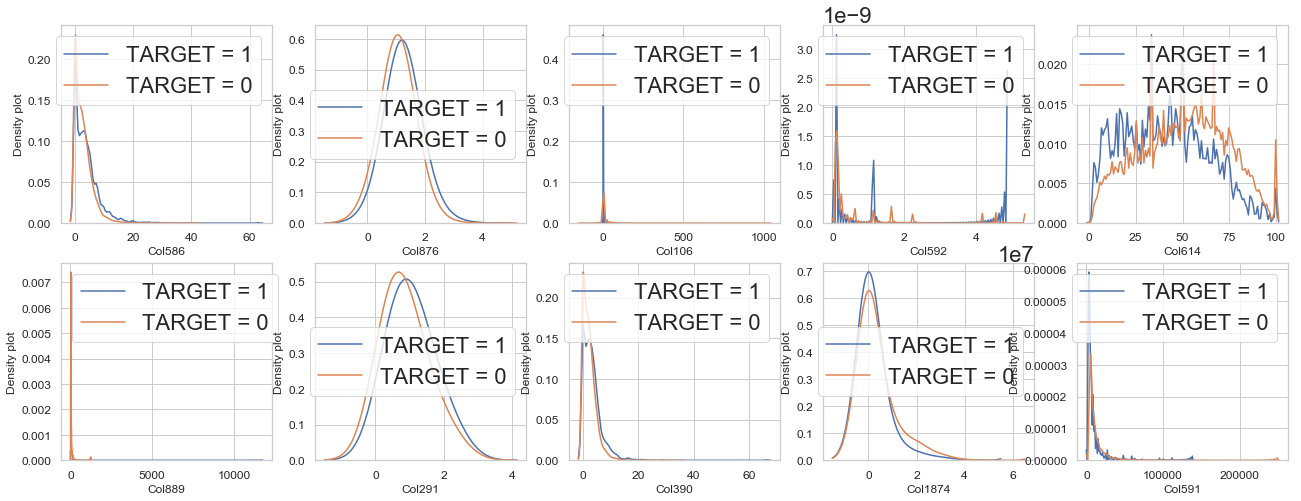

<Figure size 432x288 with 0 Axes>

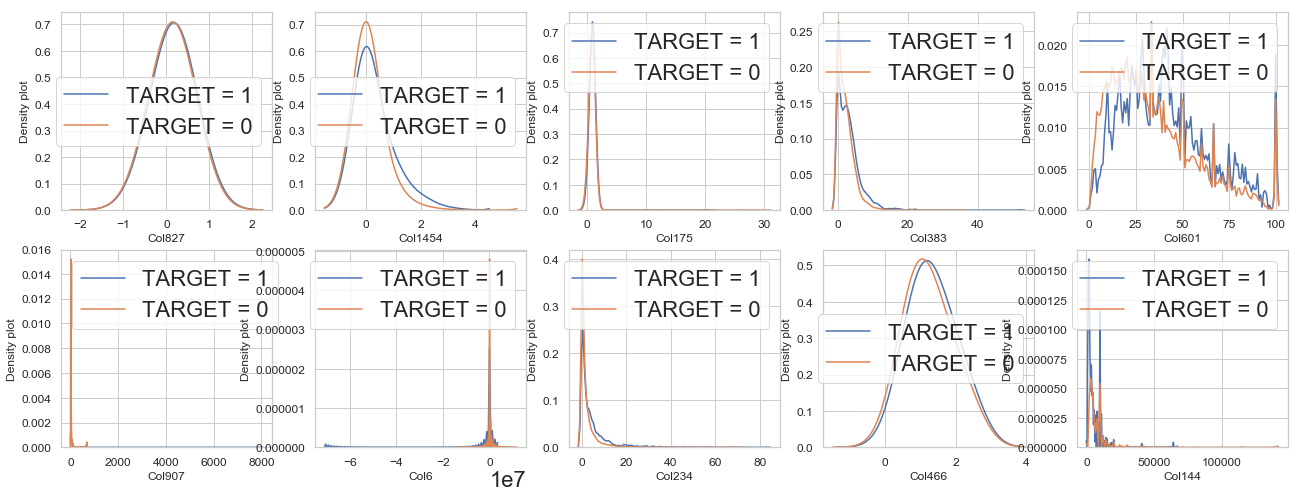

<Figure size 432x288 with 0 Axes>

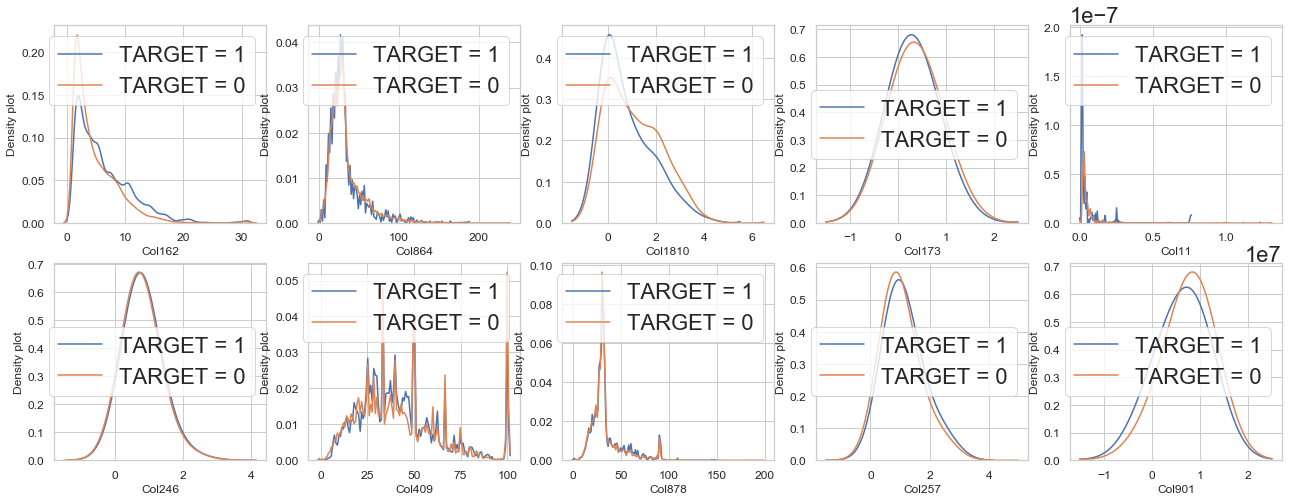

In [27]:
plot_distribution(imp_cols)

In [30]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(t1[feature], bw=0.5,label="cls: 1")
        sns.kdeplot(t0[feature], bw=0.5,label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
# for i in range(10):
#     plot_distribution(imp_cols[i*10:(i+1)*10])

<Figure size 432x288 with 0 Axes>

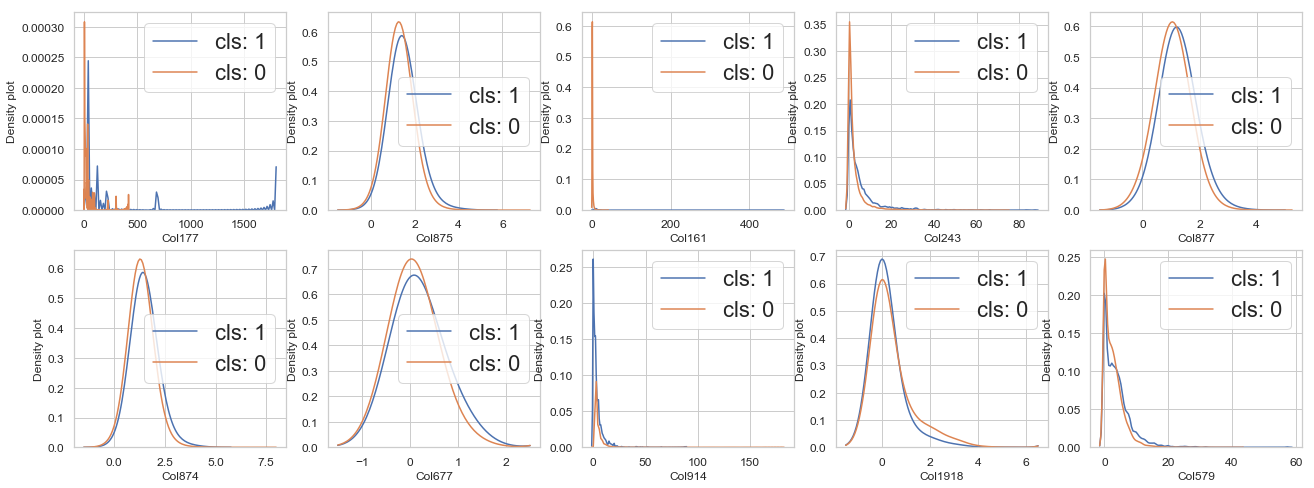

<Figure size 432x288 with 0 Axes>

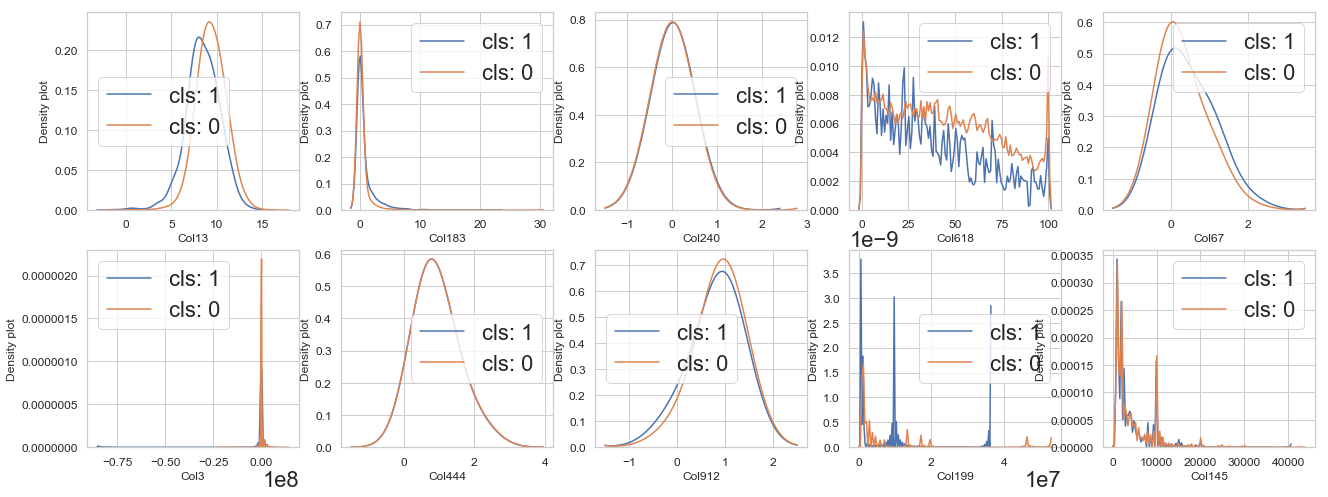

<Figure size 432x288 with 0 Axes>

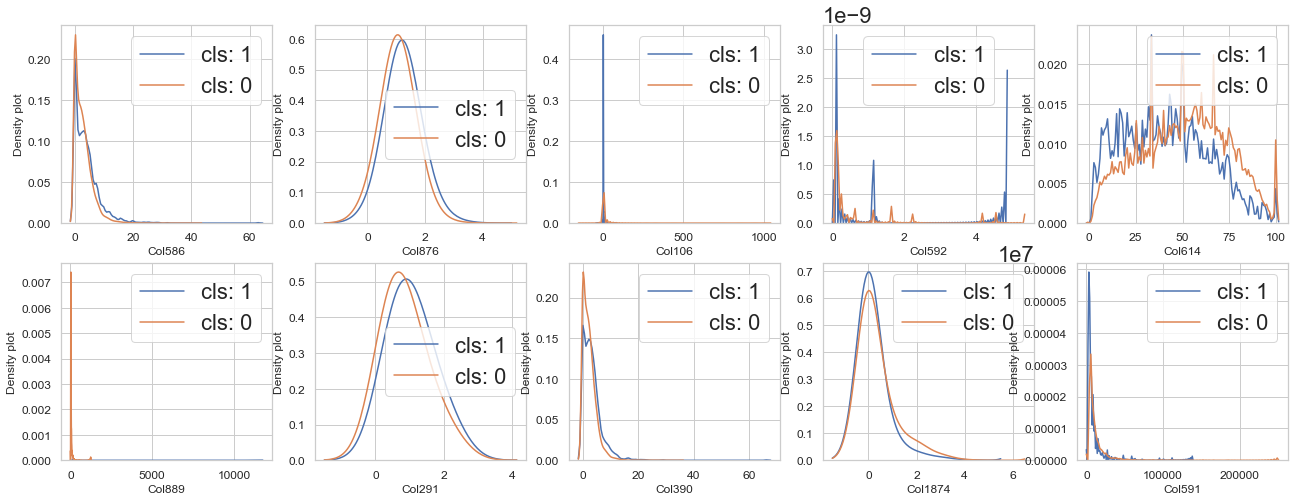

<Figure size 432x288 with 0 Axes>

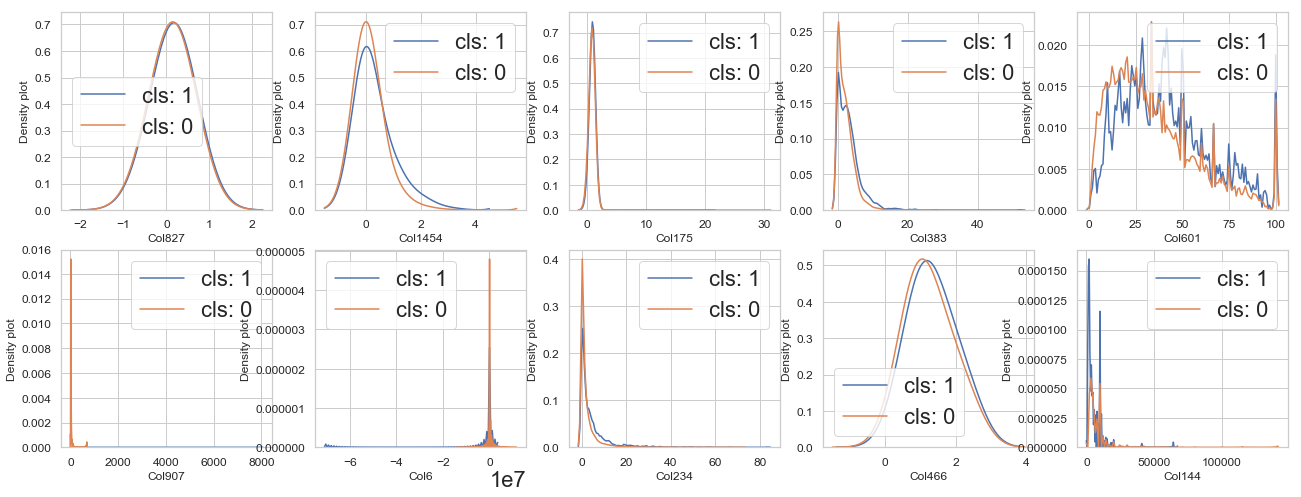

<Figure size 432x288 with 0 Axes>

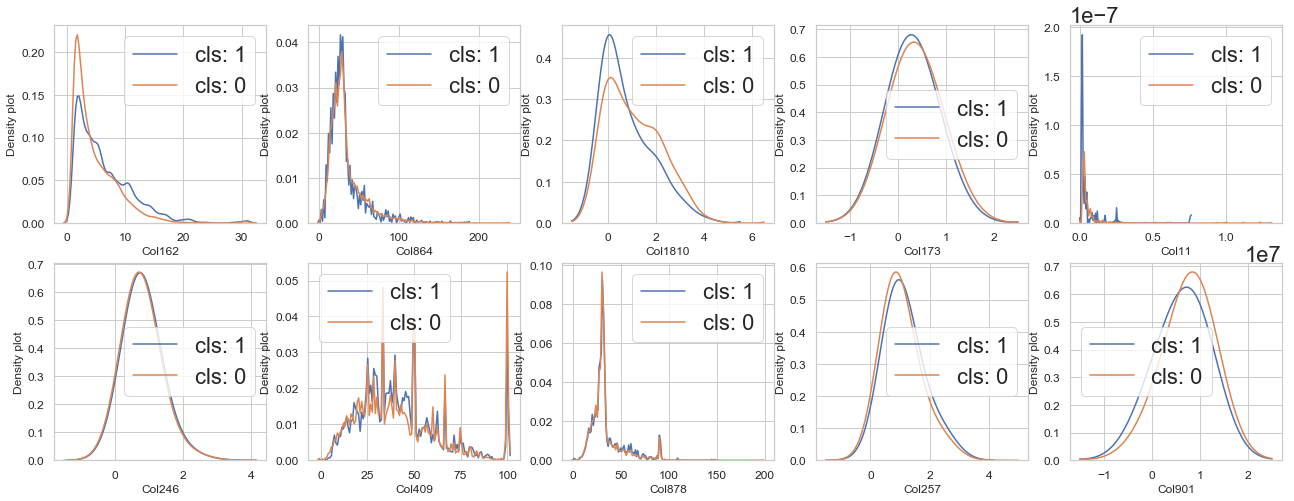

<Figure size 432x288 with 0 Axes>

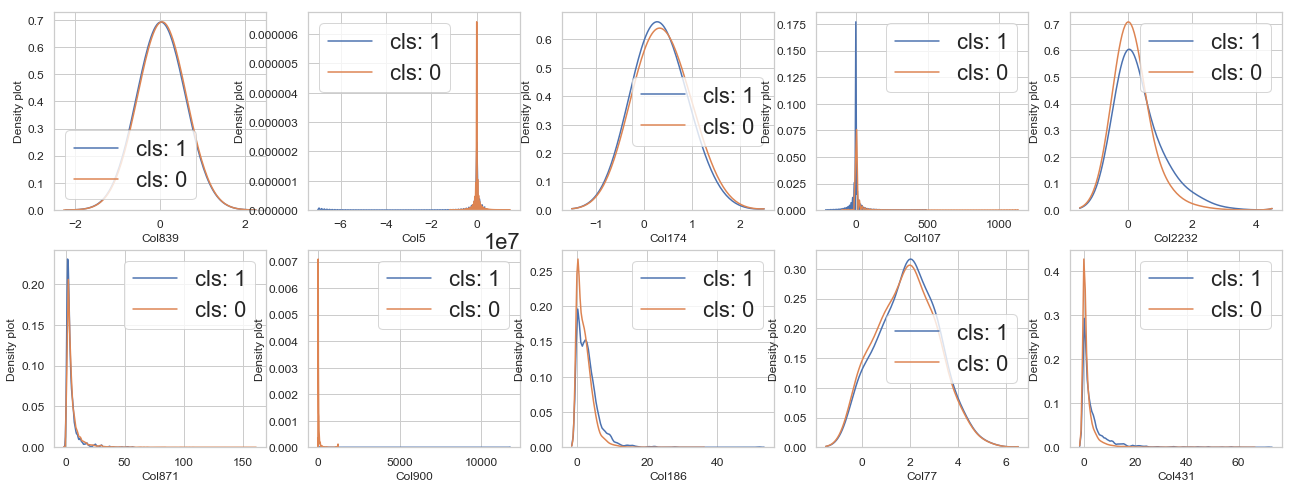

<Figure size 432x288 with 0 Axes>

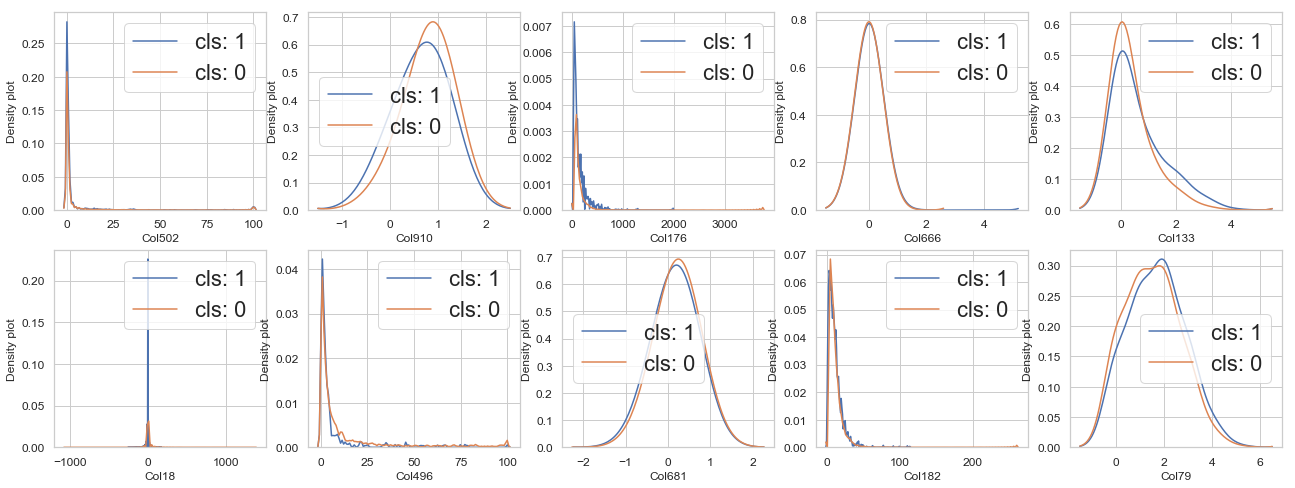

<Figure size 432x288 with 0 Axes>

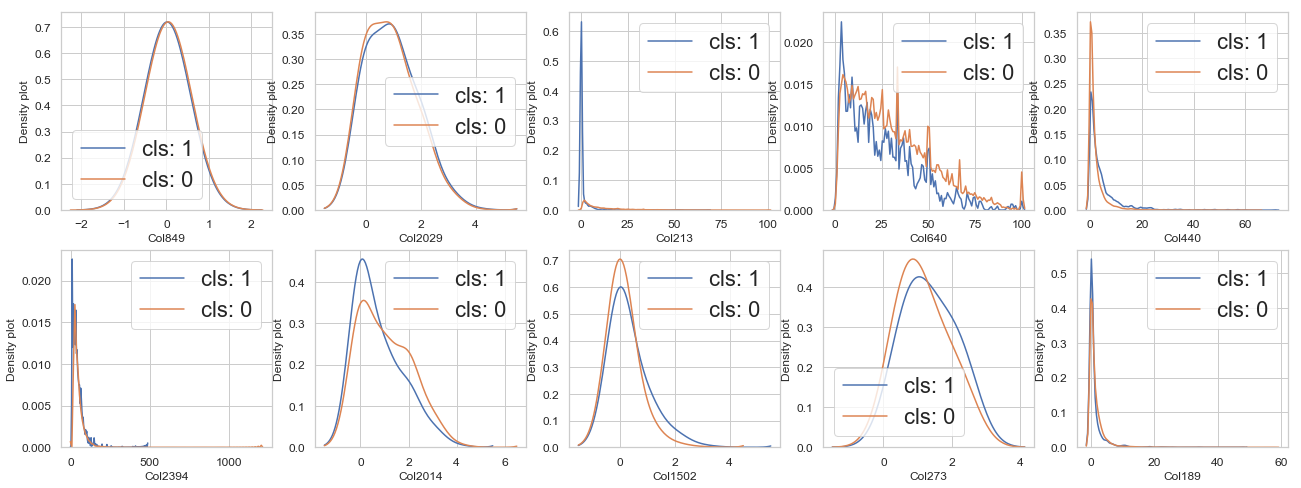

<Figure size 432x288 with 0 Axes>

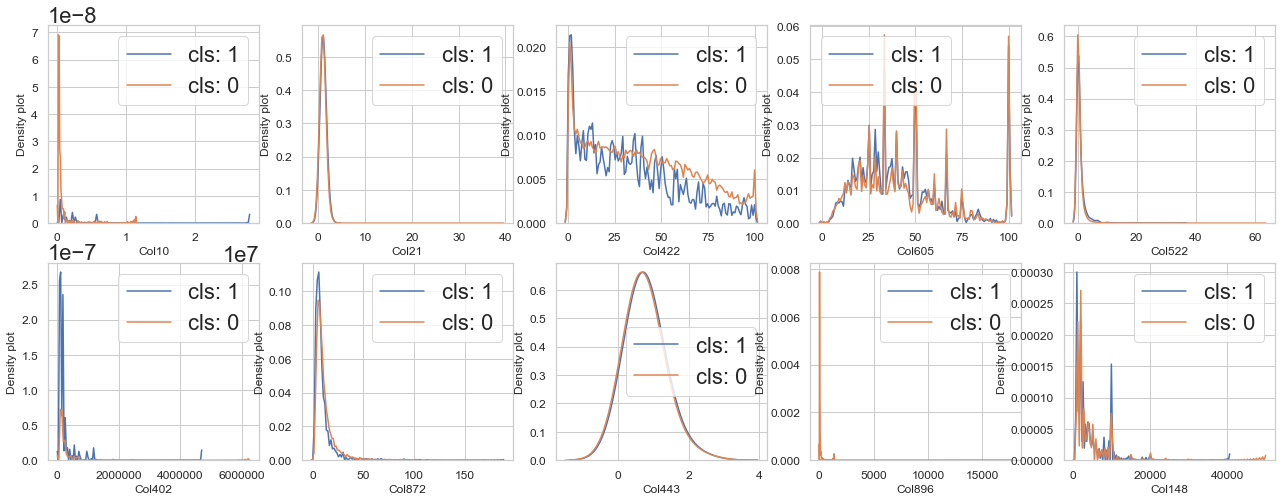

<Figure size 432x288 with 0 Axes>

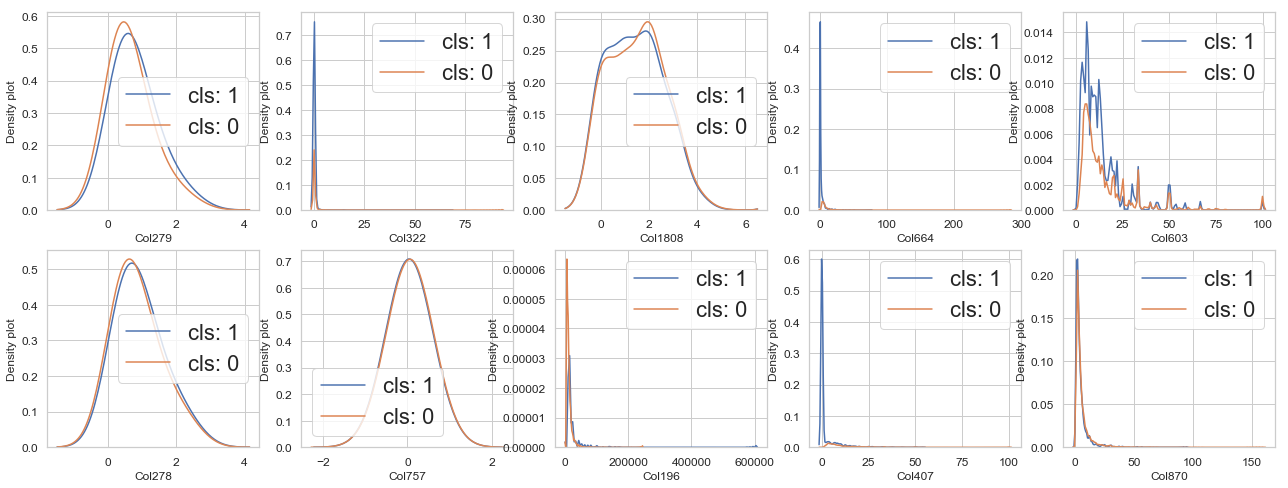

In [31]:
for i in range(10):
    plot_distribution(imp_cols[i*10:(i+1)*10])

<Figure size 432x288 with 0 Axes>

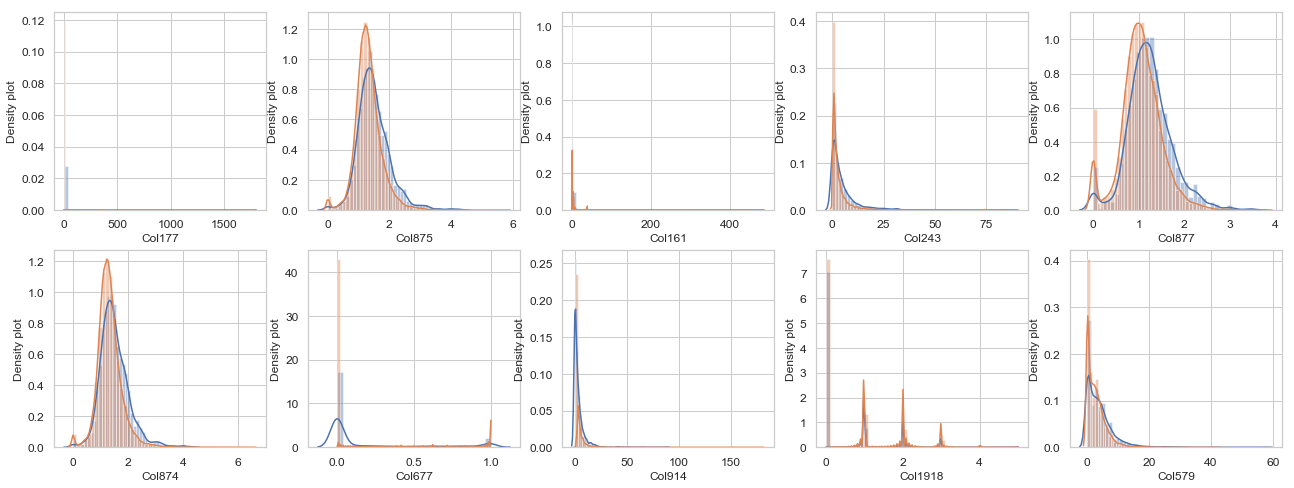

<Figure size 432x288 with 0 Axes>

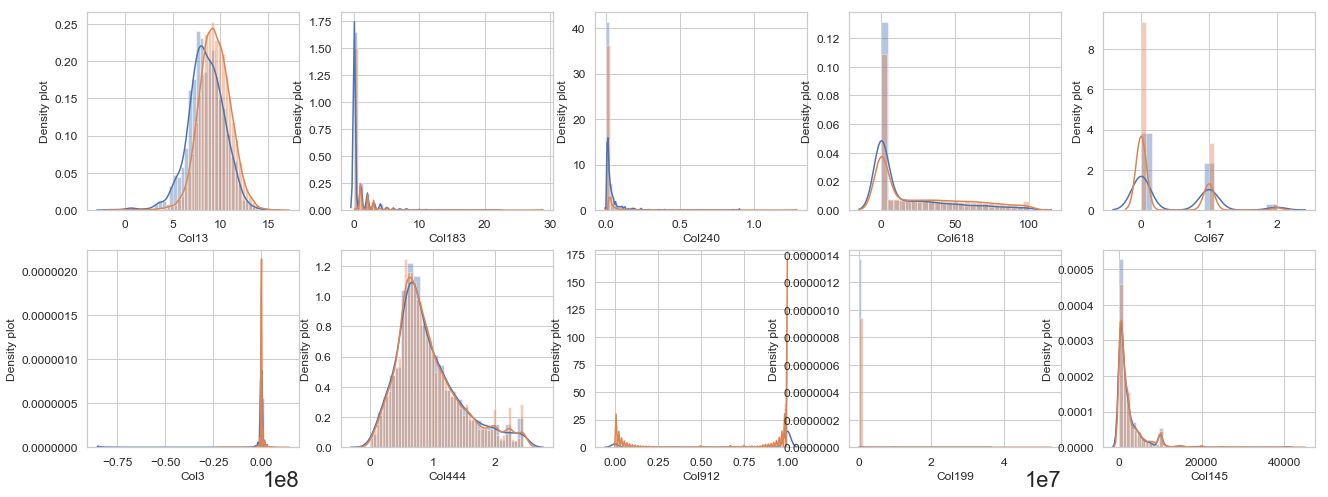

<Figure size 432x288 with 0 Axes>

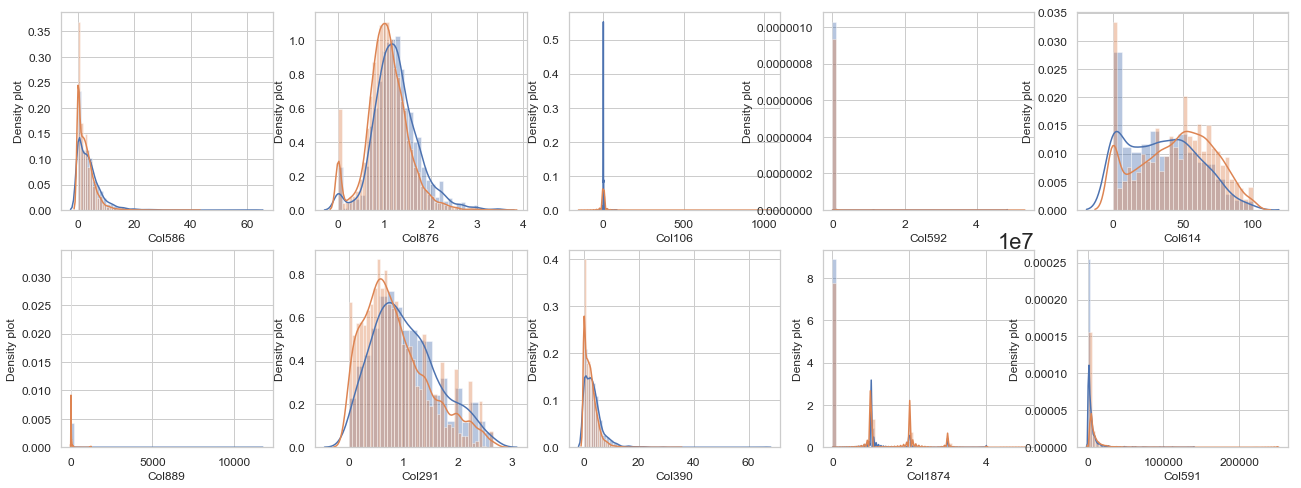

<Figure size 432x288 with 0 Axes>

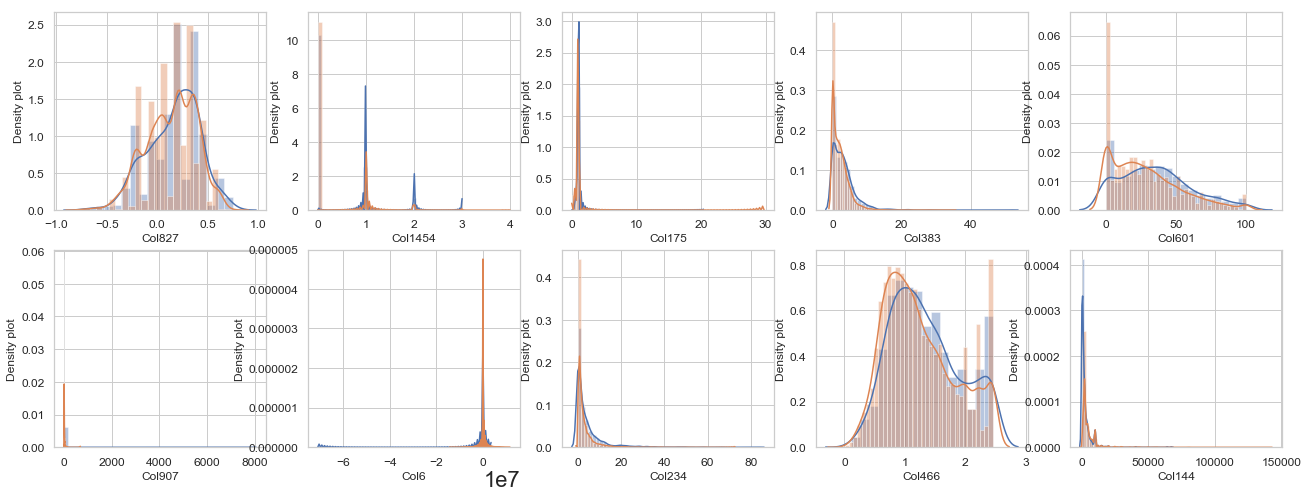

<Figure size 432x288 with 0 Axes>

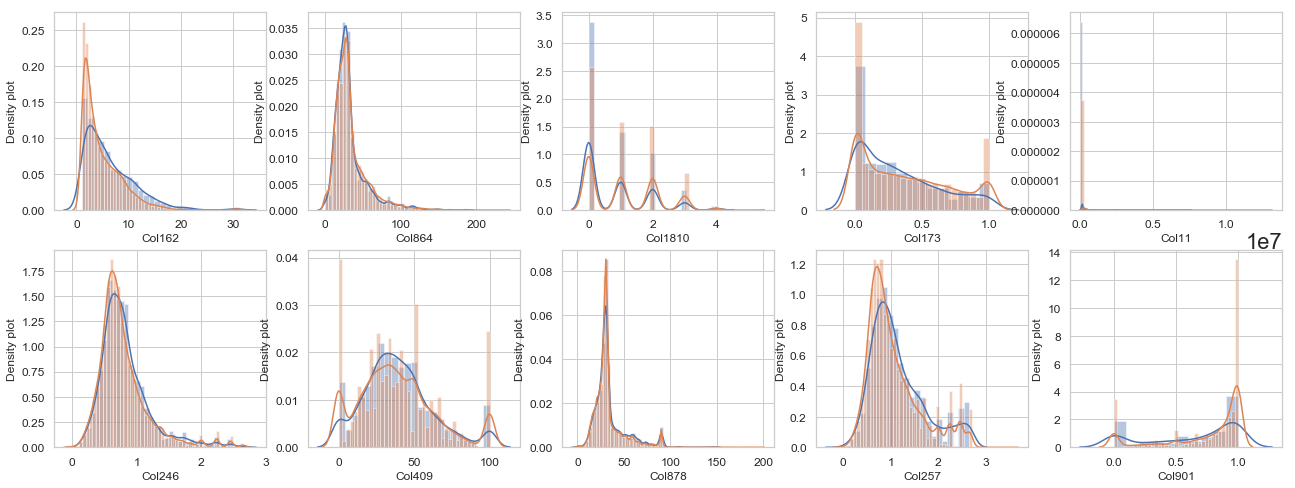

<Figure size 432x288 with 0 Axes>

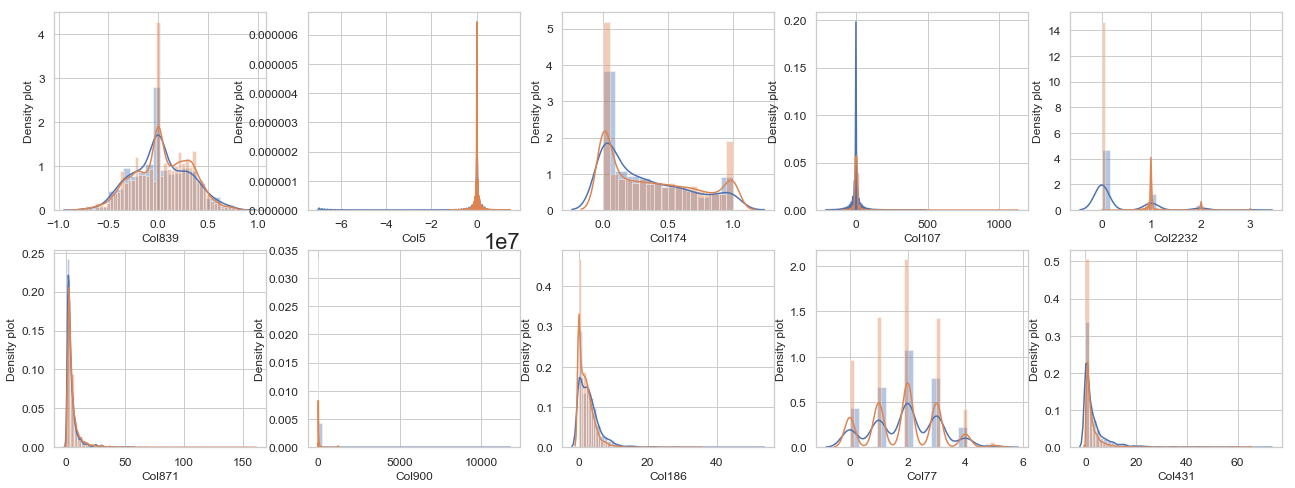

<Figure size 432x288 with 0 Axes>

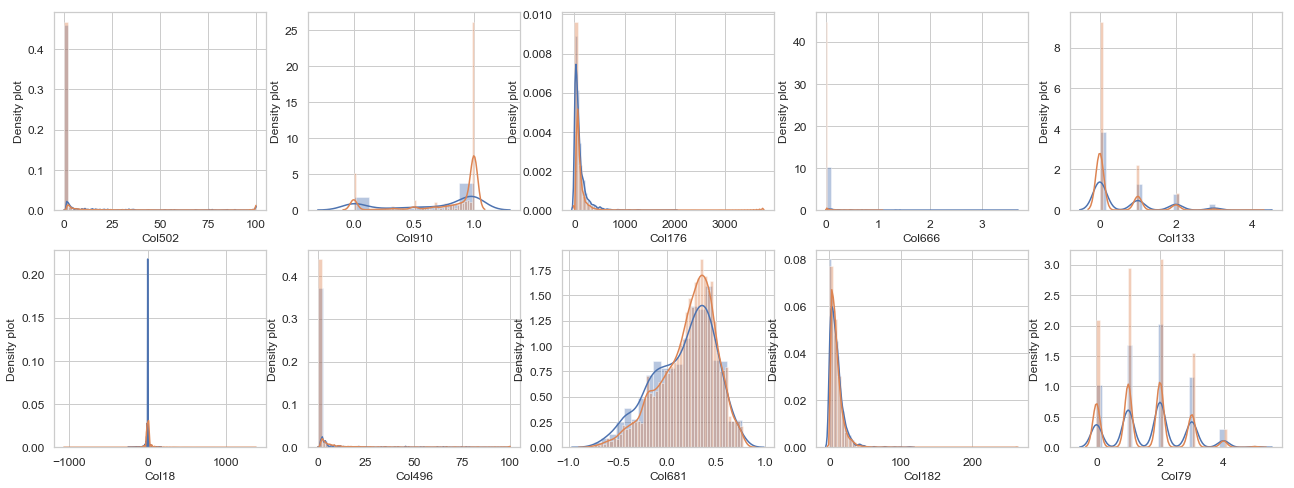

<Figure size 432x288 with 0 Axes>

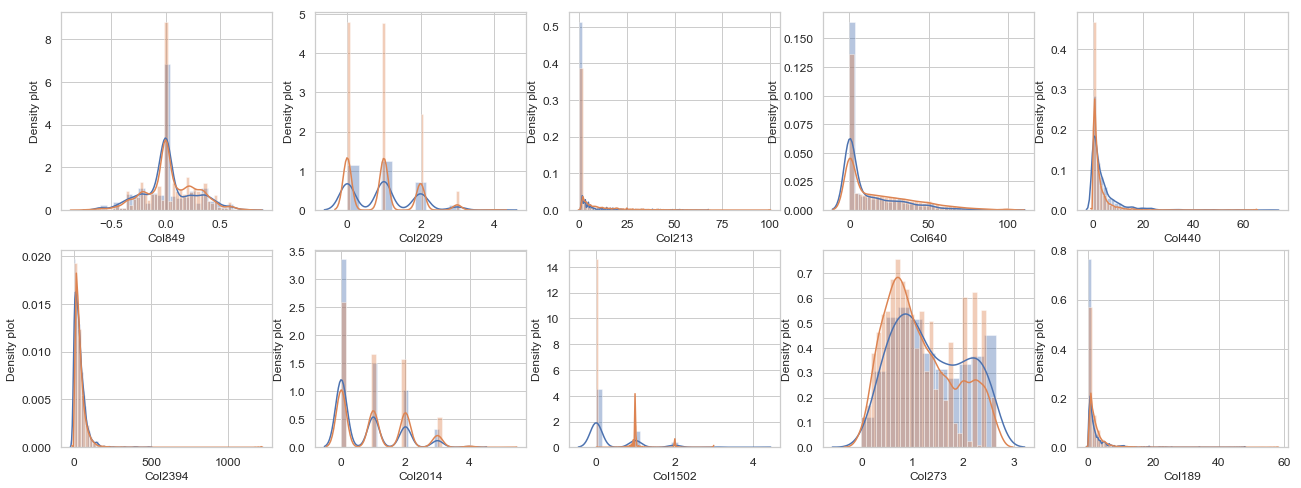

<Figure size 432x288 with 0 Axes>

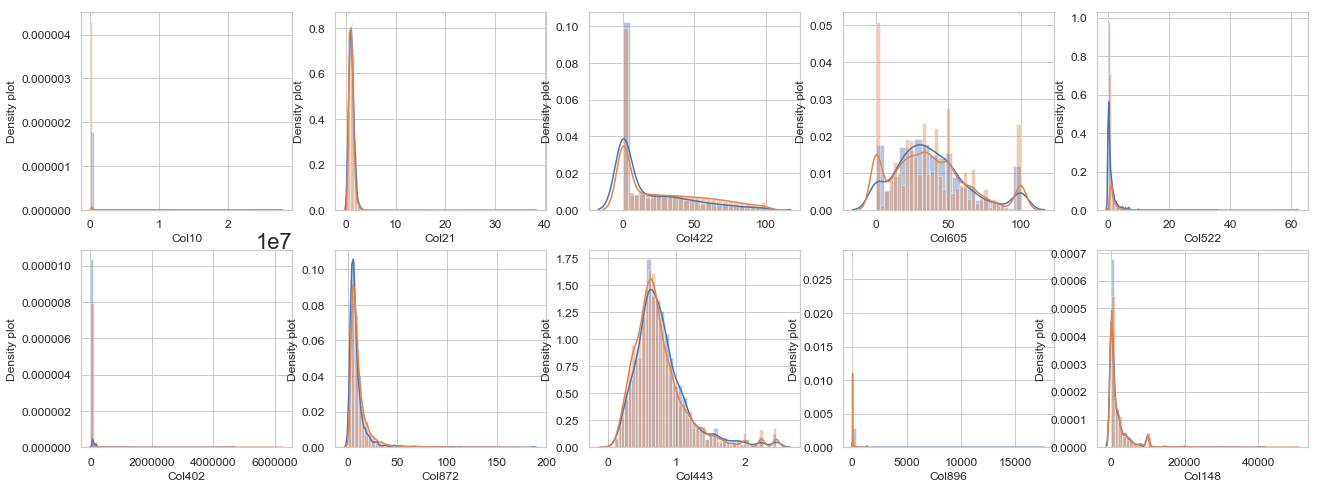

<Figure size 432x288 with 0 Axes>

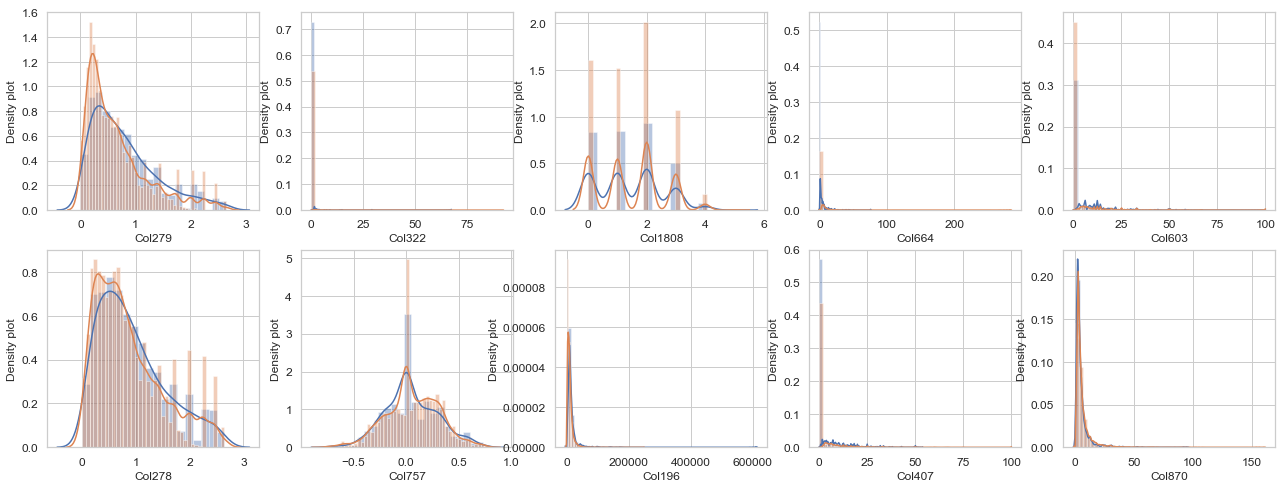

In [33]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna(),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    plot_distribution(imp_cols[i*10:(i+1)*10])

In [34]:
import random, math

def grouping_cols(df, cat_percentage = 0.05, checking_itr = 10):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc

cat_cols, num_cols = grouping_cols(train)

876 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1801, total num cols: 590

-----Filtered result after 2nd stage-----
total cat cols: 1635, total num cols: 756


In [36]:
len(set(imp_cols).intersection(set(num_cols)))

228

Printing from 0 to 10


<Figure size 432x288 with 0 Axes>

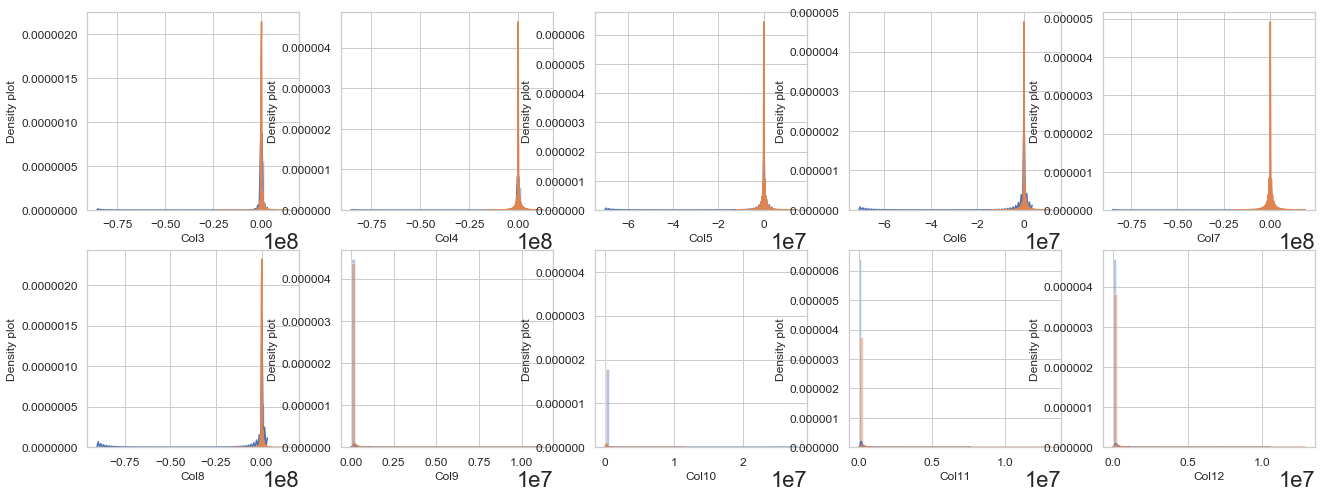

Printing from 10 to 20


<Figure size 432x288 with 0 Axes>

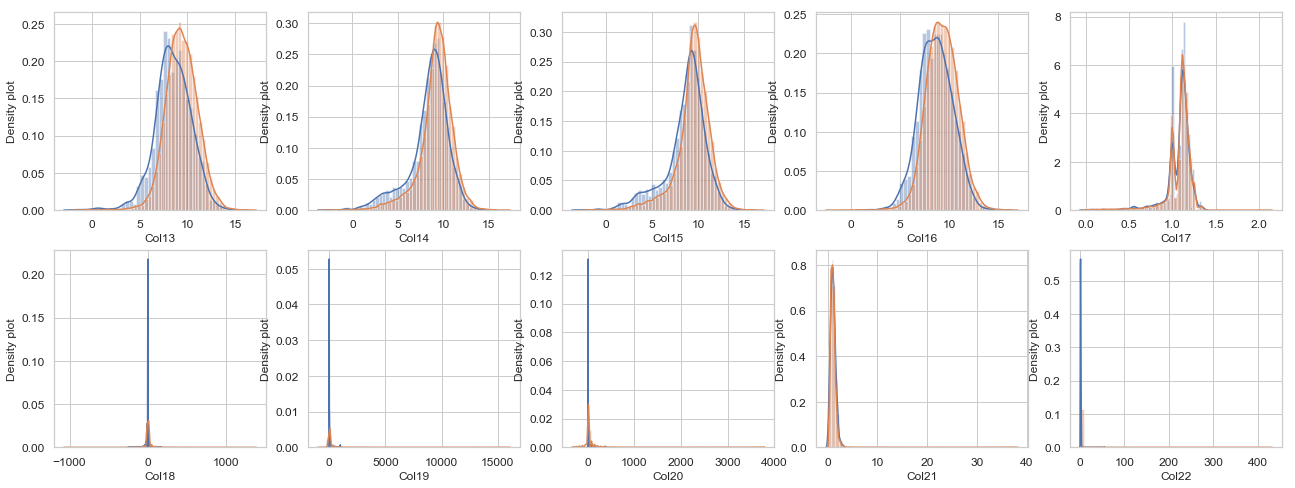

Printing from 20 to 30


<Figure size 432x288 with 0 Axes>

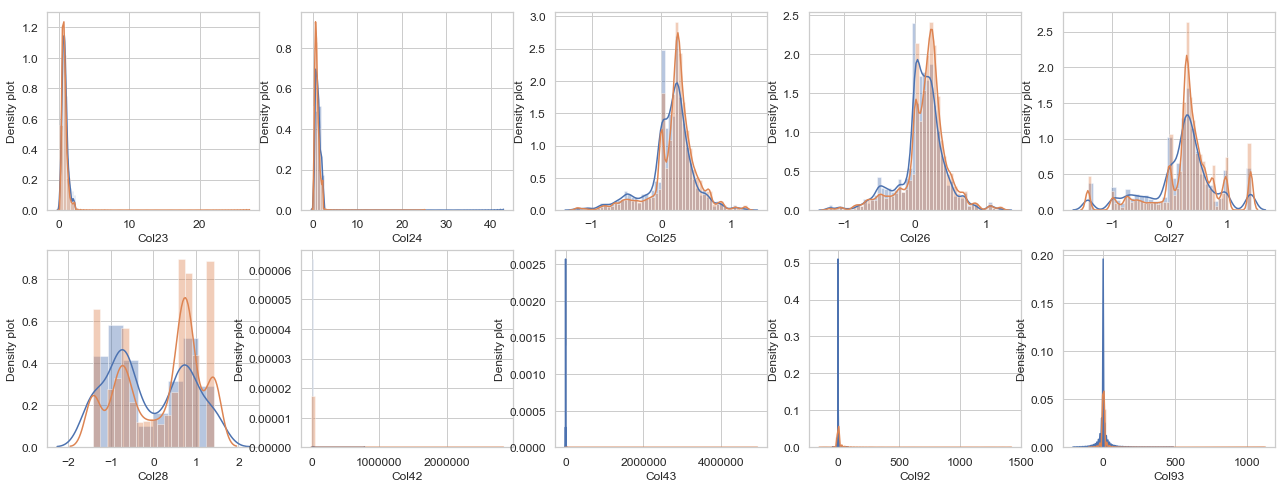

Printing from 30 to 40


<Figure size 432x288 with 0 Axes>

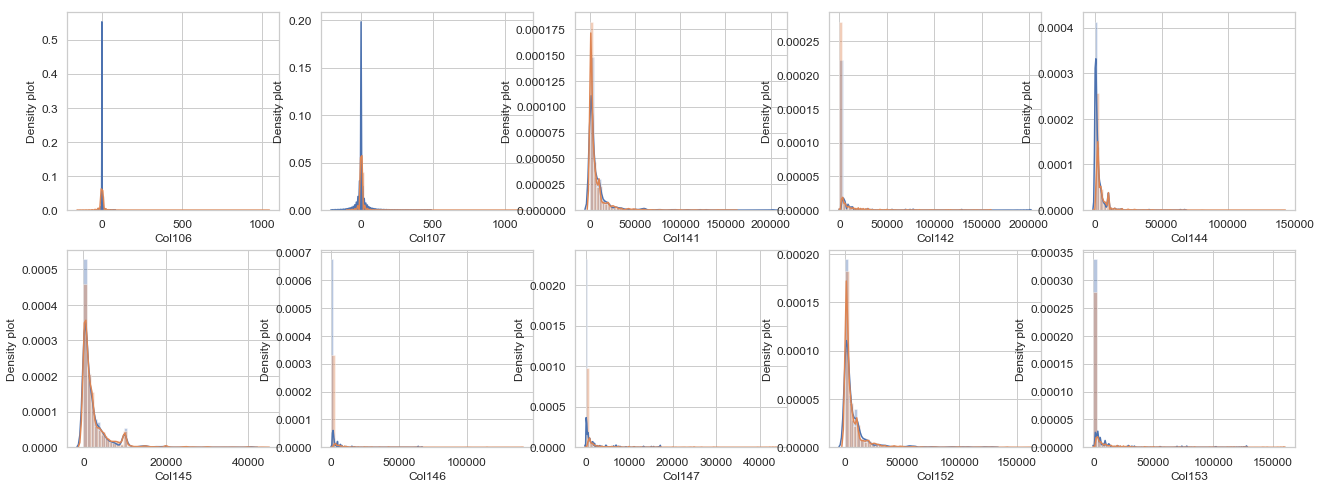

Printing from 40 to 50


<Figure size 432x288 with 0 Axes>

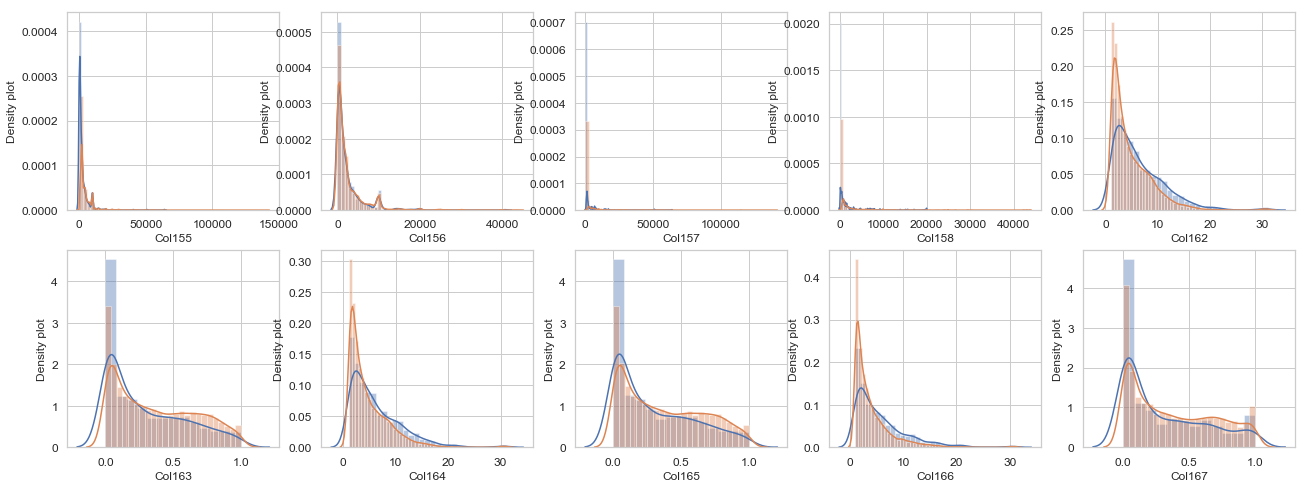

Printing from 50 to 60


<Figure size 432x288 with 0 Axes>

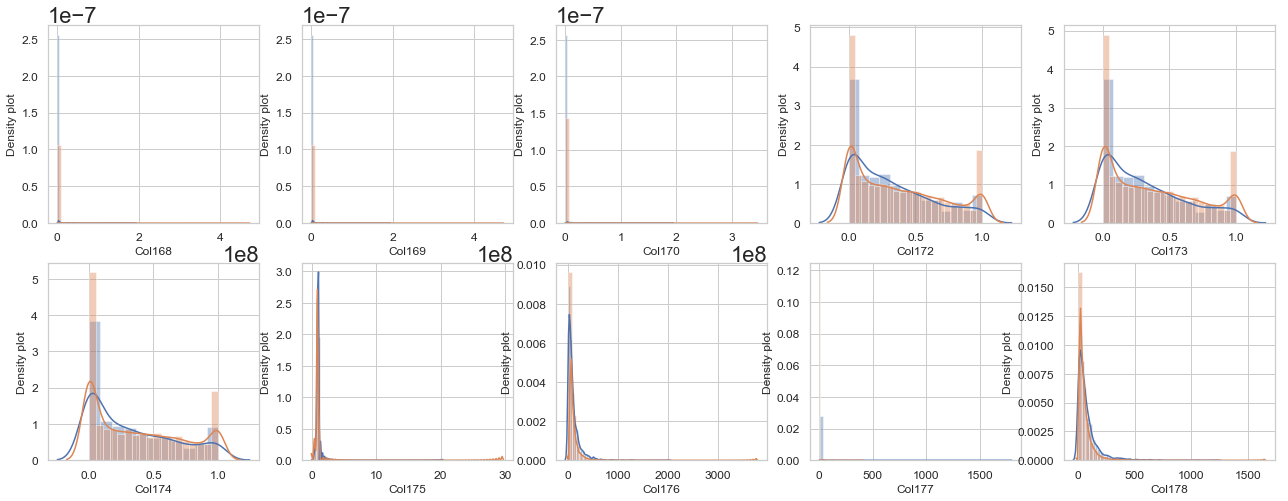

Printing from 60 to 70


<Figure size 432x288 with 0 Axes>

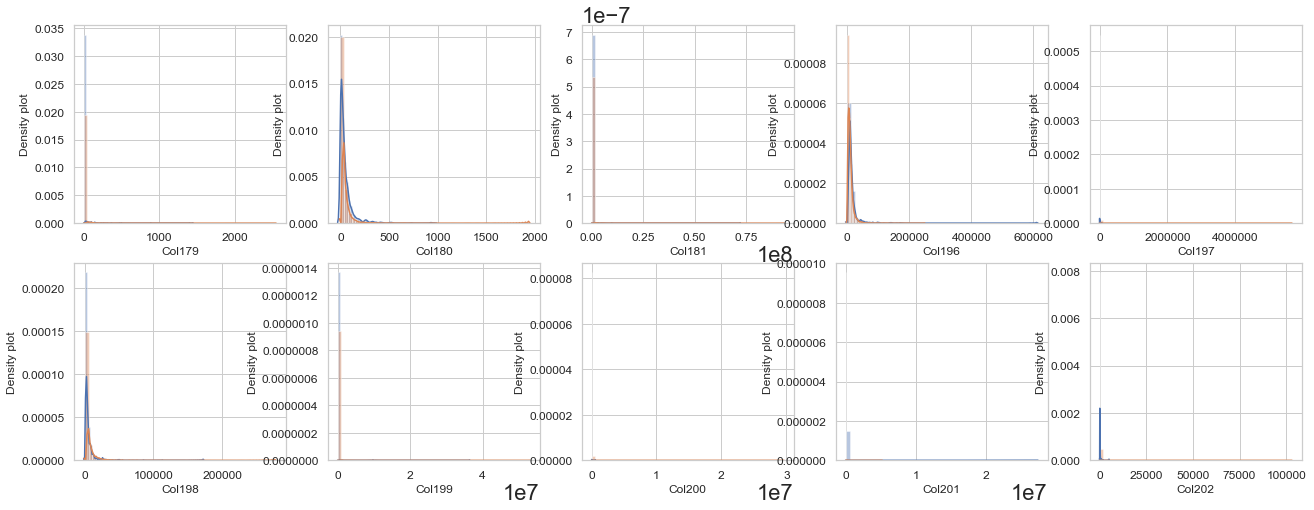

Printing from 70 to 80


<Figure size 432x288 with 0 Axes>

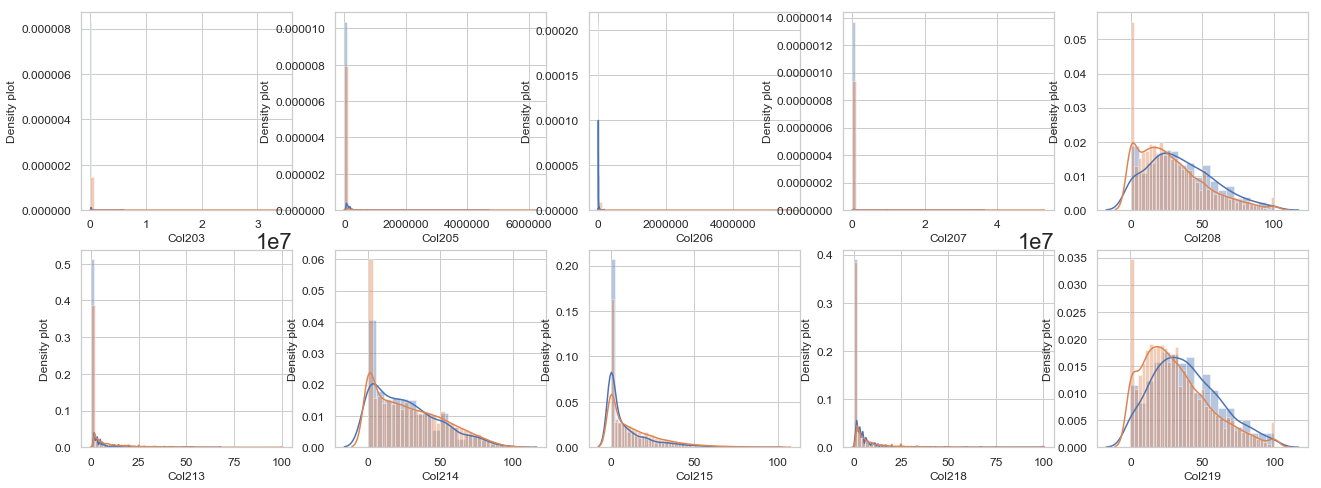

Printing from 80 to 90


<Figure size 432x288 with 0 Axes>

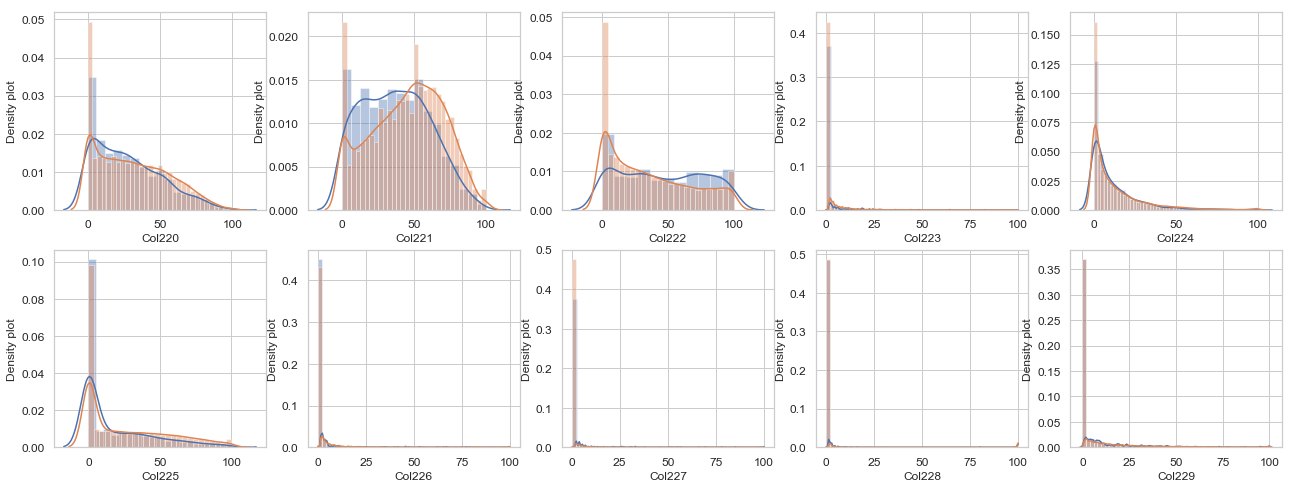

Printing from 90 to 100


<Figure size 432x288 with 0 Axes>

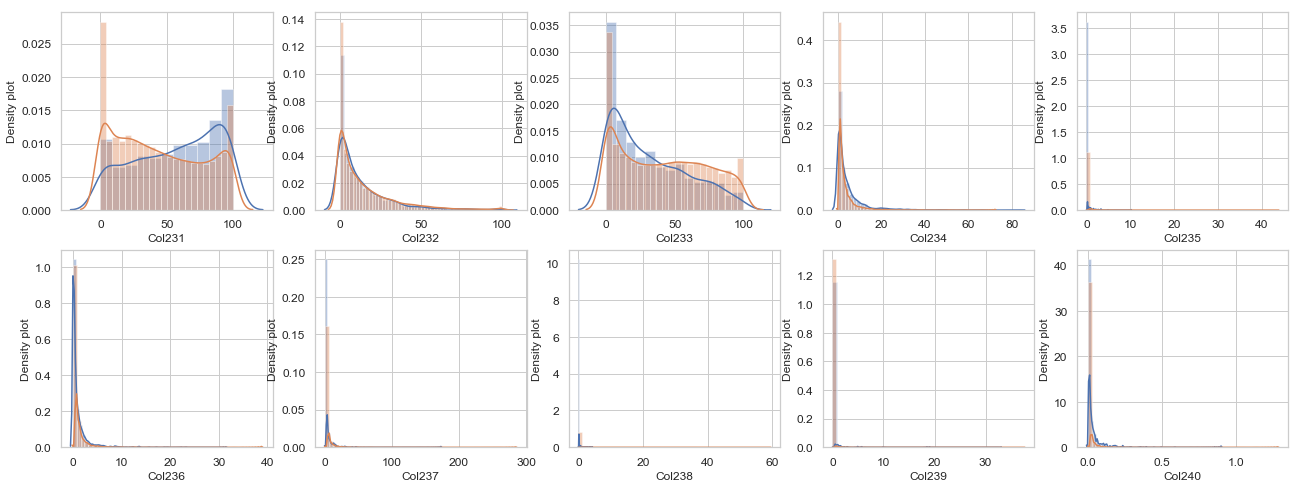

In [35]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna(),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(num_cols[i*10:(i+1)*10])

In [54]:
train1 = train.copy()
train1.dropna(axis=0).shape, train1.dropna(axis=1).shape

((0, 2391), (17521, 1634))

In [61]:
cat_cols

['Col29',
 'Col30',
 'Col31',
 'Col32',
 'Col33',
 'Col34',
 'Col35',
 'Col36',
 'Col37',
 'Col38',
 'Col39',
 'Col40',
 'Col41',
 'Col44',
 'Col45',
 'Col46',
 'Col47',
 'Col48',
 'Col49',
 'Col50',
 'Col51',
 'Col52',
 'Col53',
 'Col54',
 'Col55',
 'Col56',
 'Col57',
 'Col58',
 'Col59',
 'Col60',
 'Col61',
 'Col62',
 'Col63',
 'Col64',
 'Col65',
 'Col66',
 'Col67',
 'Col68',
 'Col69',
 'Col70',
 'Col71',
 'Col72',
 'Col73',
 'Col74',
 'Col75',
 'Col76',
 'Col77',
 'Col78',
 'Col79',
 'Col80',
 'Col81',
 'Col82',
 'Col83',
 'Col84',
 'Col85',
 'Col86',
 'Col87',
 'Col88',
 'Col89',
 'Col90',
 'Col91',
 'Col94',
 'Col95',
 'Col96',
 'Col97',
 'Col98',
 'Col99',
 'Col100',
 'Col101',
 'Col102',
 'Col103',
 'Col104',
 'Col105',
 'Col108',
 'Col109',
 'Col110',
 'Col111',
 'Col112',
 'Col113',
 'Col114',
 'Col115',
 'Col116',
 'Col117',
 'Col118',
 'Col119',
 'Col120',
 'Col121',
 'Col122',
 'Col123',
 'Col124',
 'Col125',
 'Col126',
 'Col127',
 'Col128',
 'Col129',
 'Col130',
 'Col131',


In [65]:
train['Col32'].value_counts()

1      11360
2       4182
3       1186
4        431
5        126
6         74
7         50
8         25
13        13
10        13
9         11
11        10
12         8
14         5
15         3
21         3
19         3
16         3
18         2
22         1
23         1
24         1
68         1
36         1
20         1
25         1
26         1
27         1
28         1
17         1
44         1
134        1
Name: Col32, dtype: int64

Printing from 0 to 10


<Figure size 432x288 with 0 Axes>

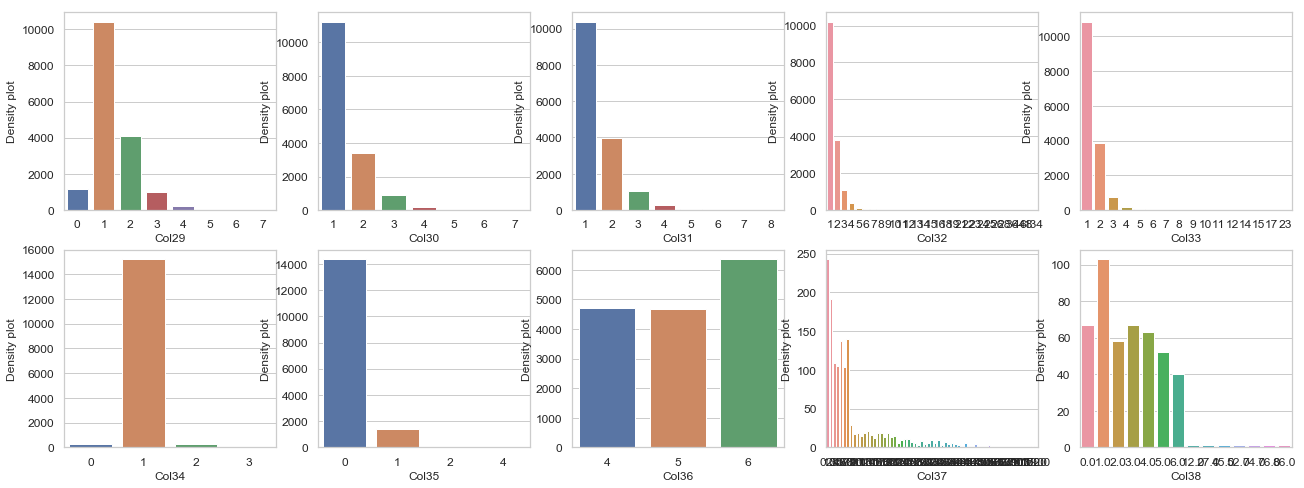

Printing from 10 to 20


<Figure size 432x288 with 0 Axes>

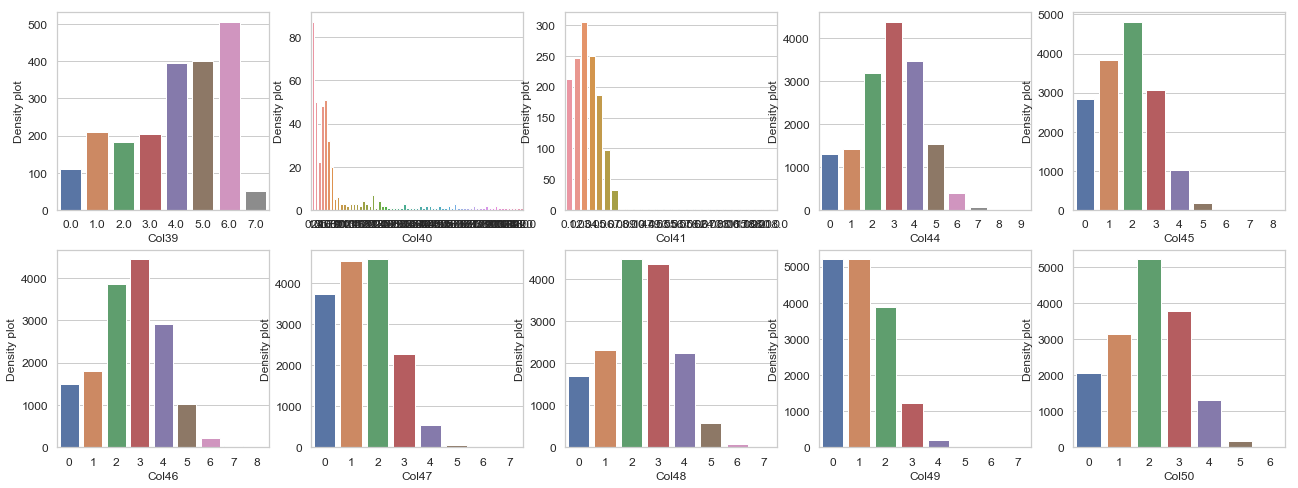

Printing from 20 to 30


<Figure size 432x288 with 0 Axes>

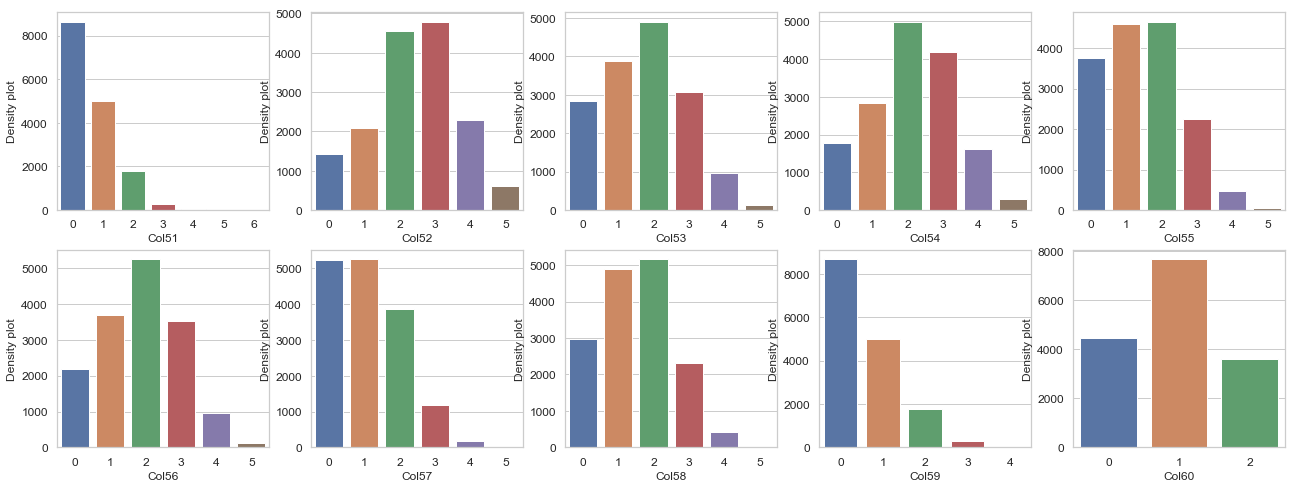

Printing from 30 to 40


<Figure size 432x288 with 0 Axes>

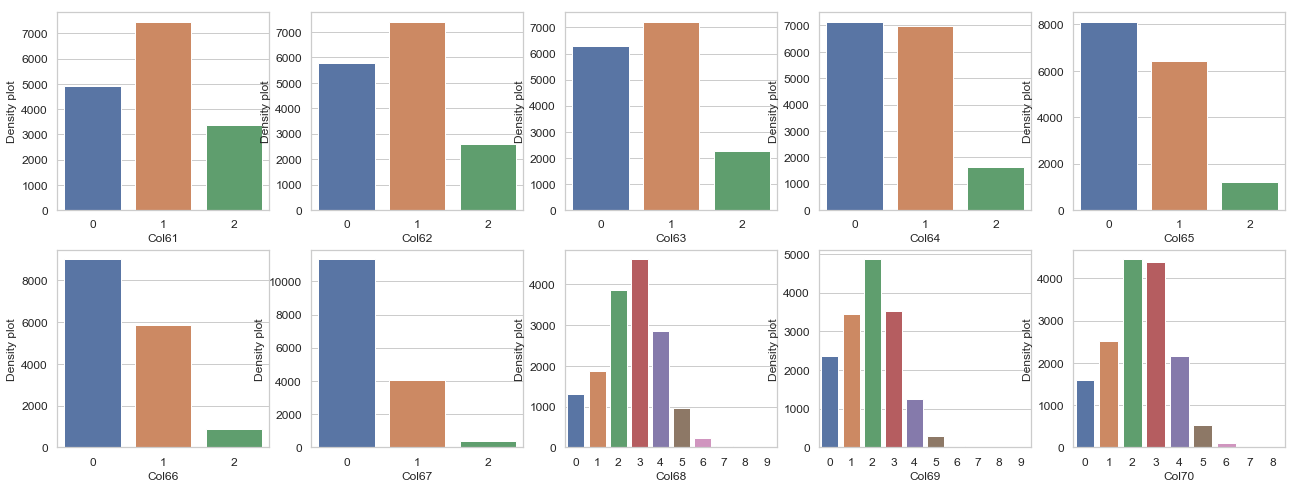

Printing from 40 to 50


<Figure size 432x288 with 0 Axes>

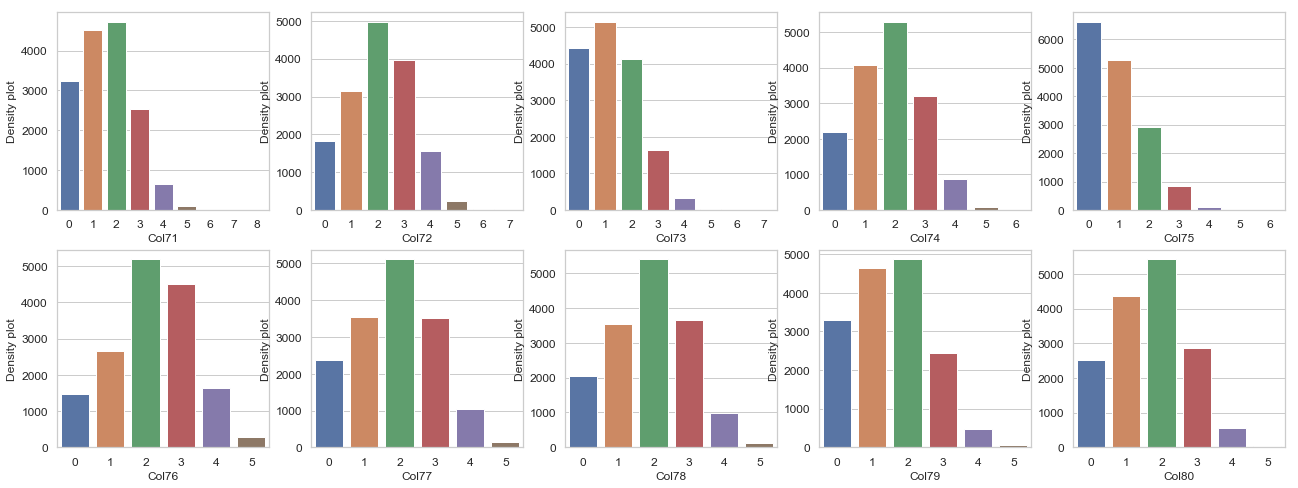

Printing from 50 to 60


<Figure size 432x288 with 0 Axes>

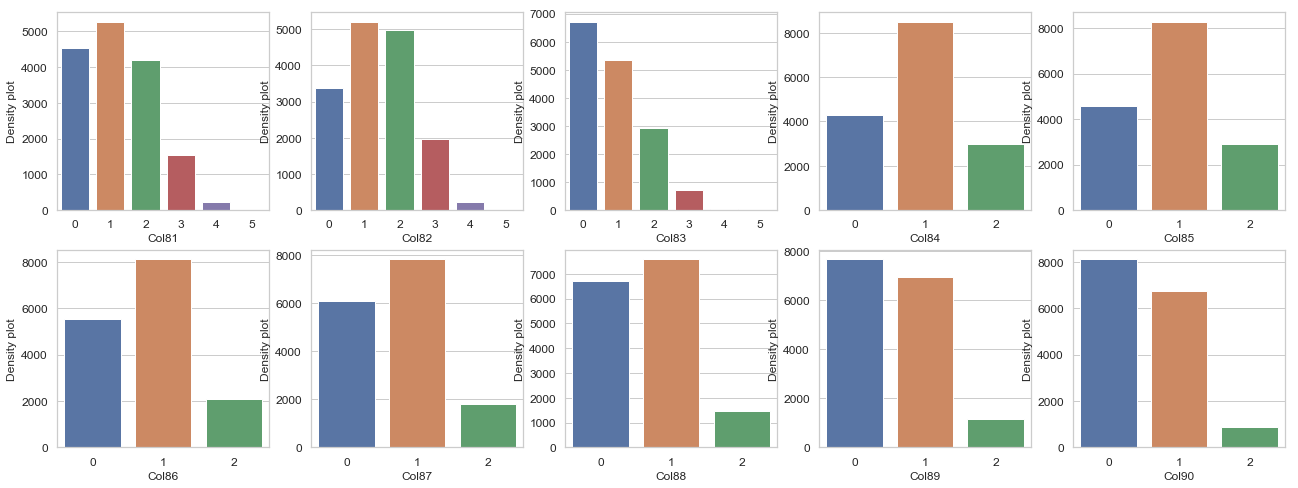

Printing from 60 to 70


<Figure size 432x288 with 0 Axes>

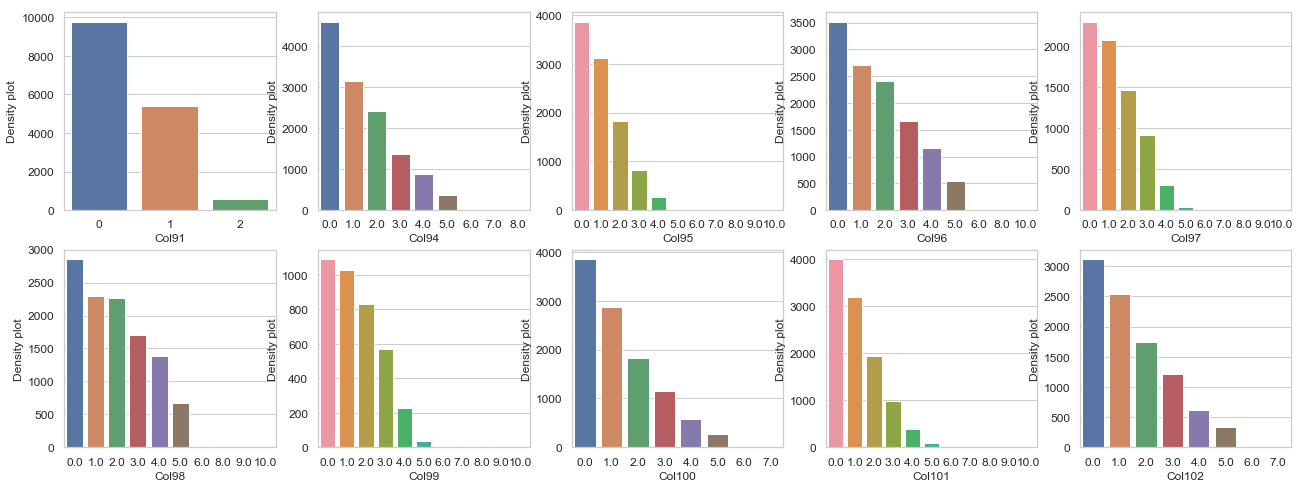

Printing from 70 to 80


<Figure size 432x288 with 0 Axes>

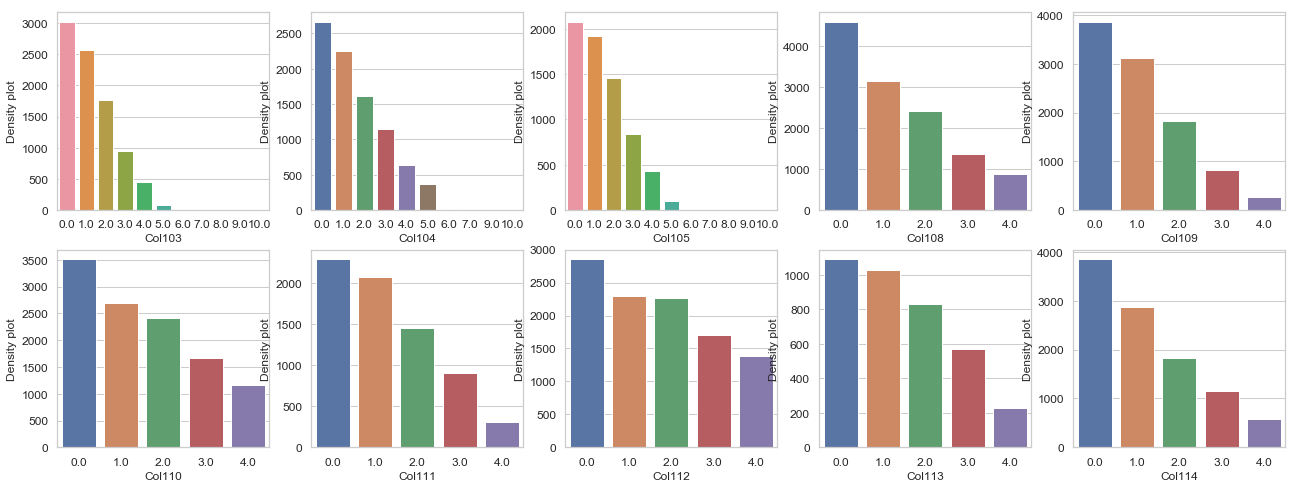

Printing from 80 to 90


<Figure size 432x288 with 0 Axes>

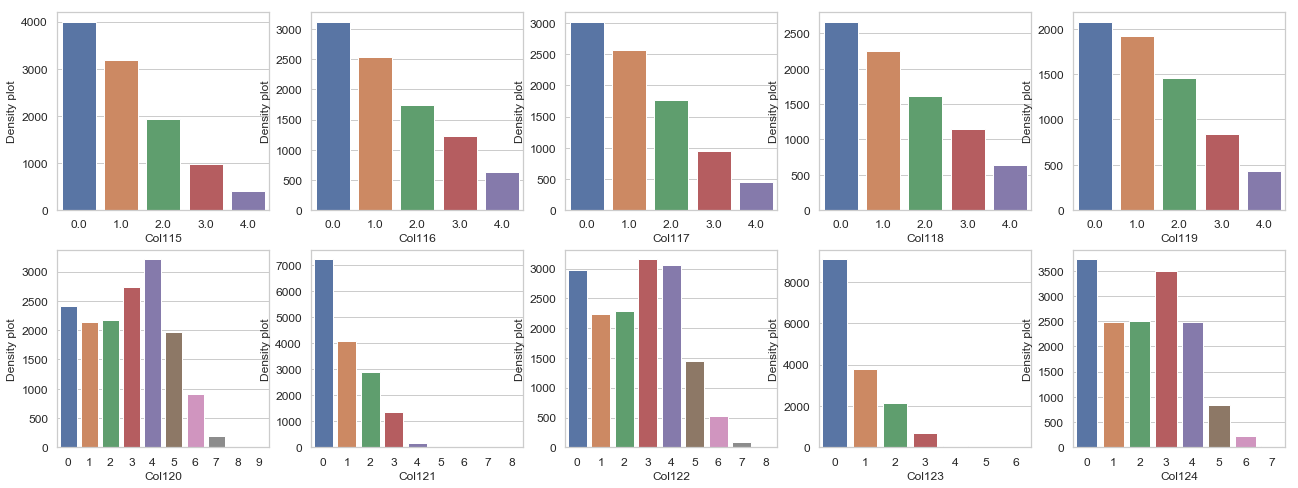

Printing from 90 to 100


<Figure size 432x288 with 0 Axes>

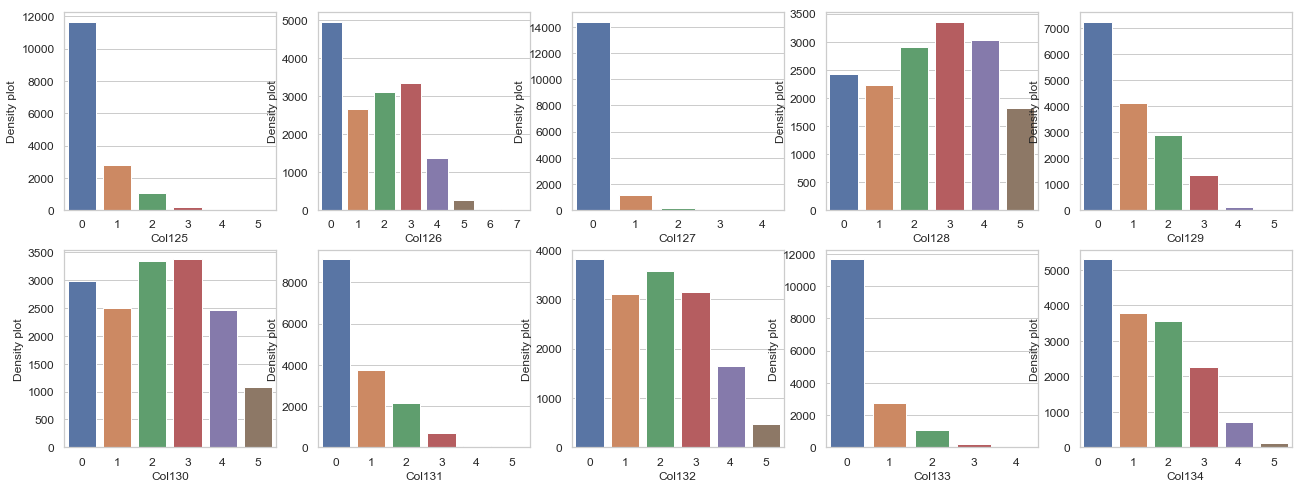

In [62]:
def plot_cat_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.countplot(t1[feature],label="cls: 1")
        sns.countplot(t0[feature],label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

Printing from 100 to 110


<Figure size 432x288 with 0 Axes>

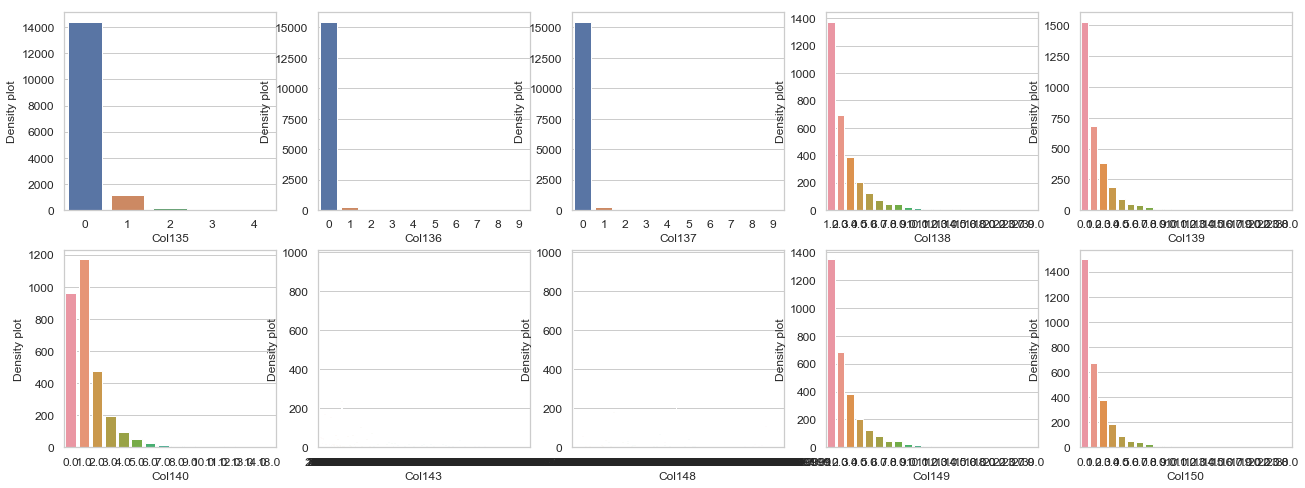

Printing from 110 to 120


<Figure size 432x288 with 0 Axes>

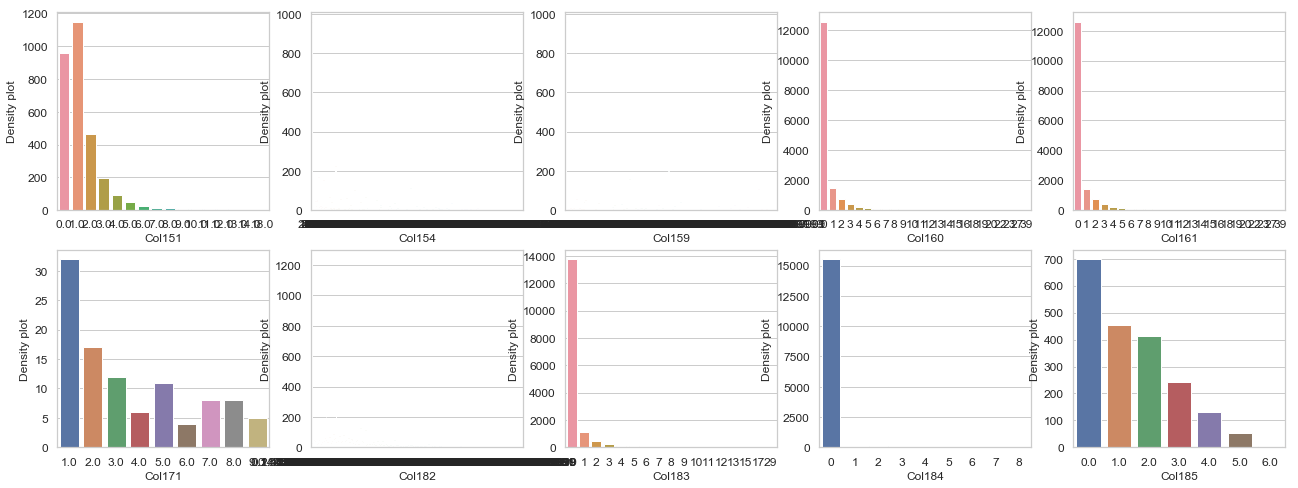

Printing from 120 to 130


<Figure size 432x288 with 0 Axes>

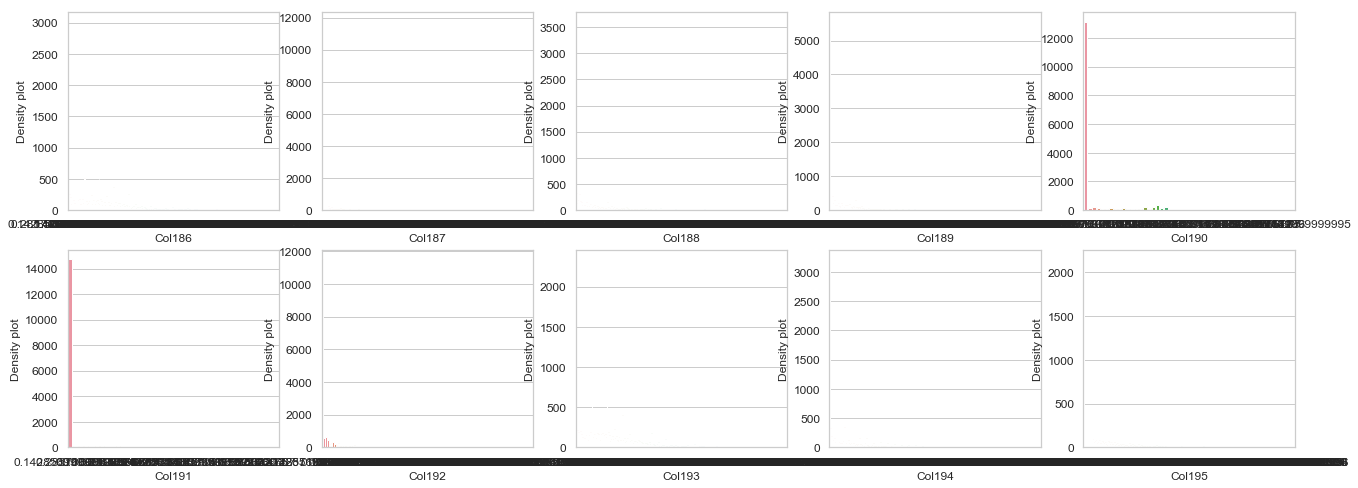

Printing from 130 to 140


<Figure size 432x288 with 0 Axes>

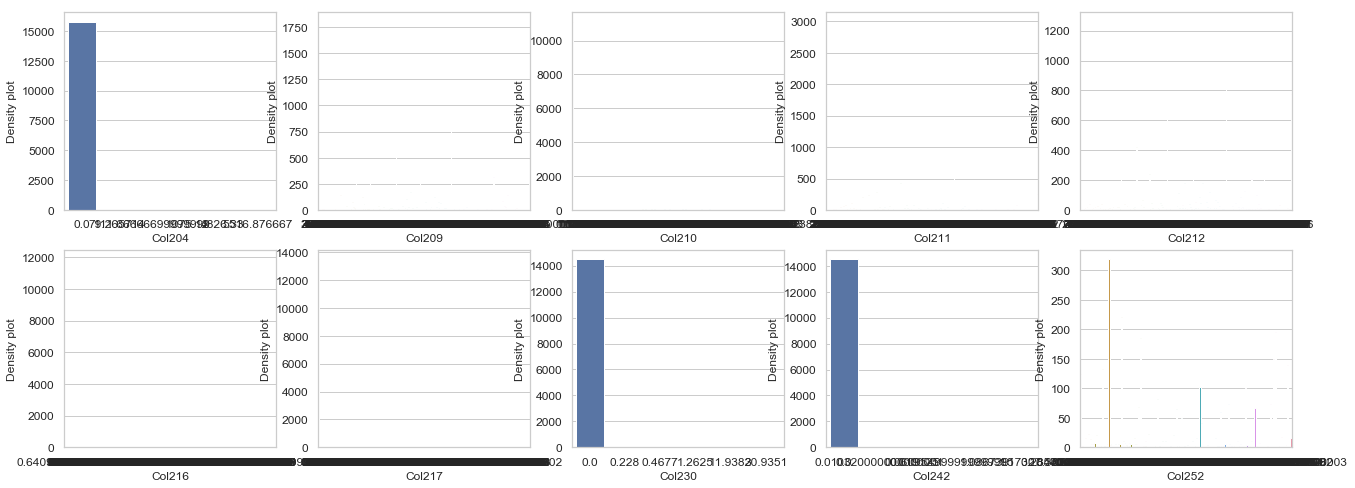

Printing from 140 to 150


<Figure size 432x288 with 0 Axes>

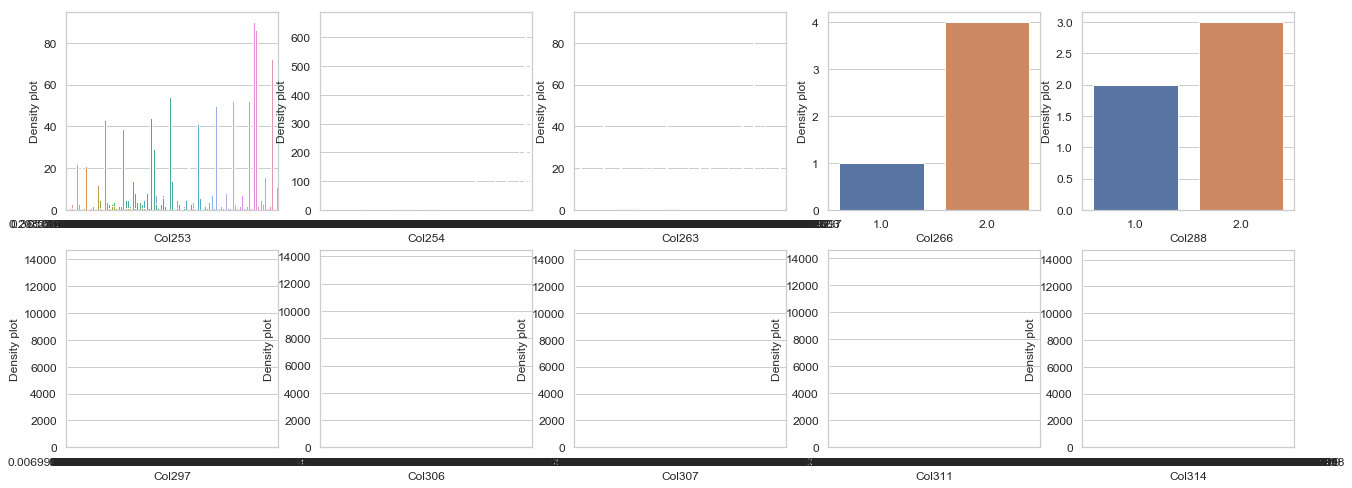

Printing from 150 to 160


<Figure size 432x288 with 0 Axes>

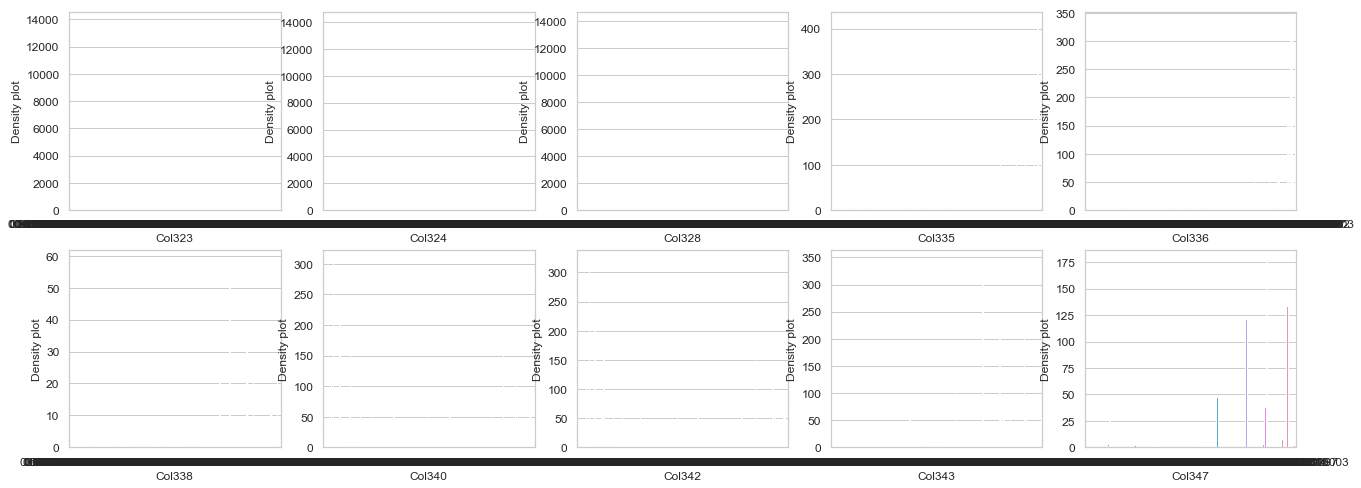

Printing from 160 to 170


<Figure size 432x288 with 0 Axes>

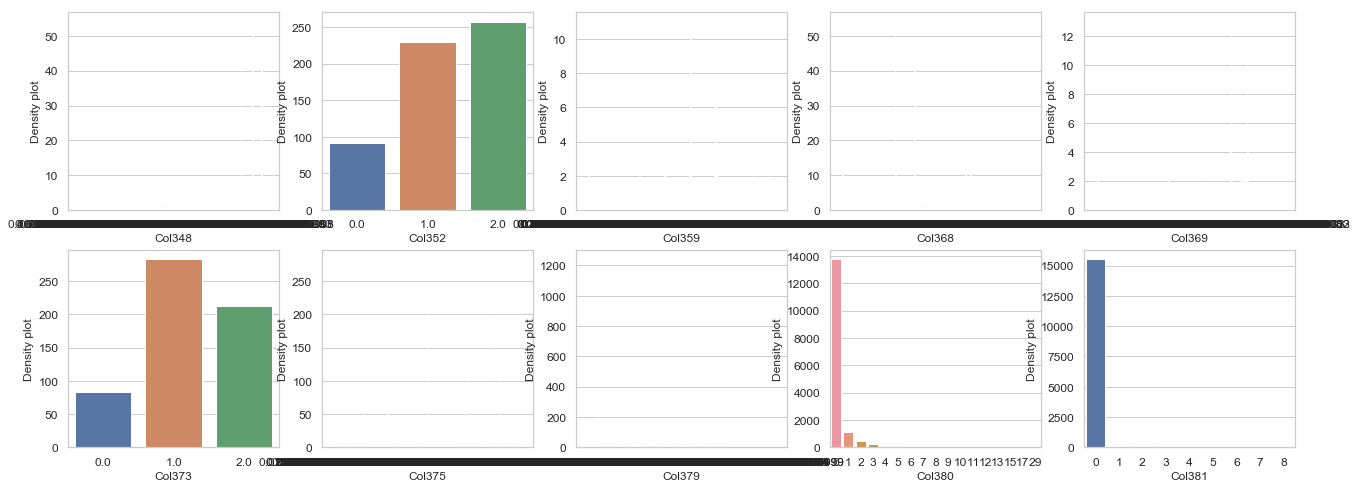

Printing from 170 to 180


<Figure size 432x288 with 0 Axes>

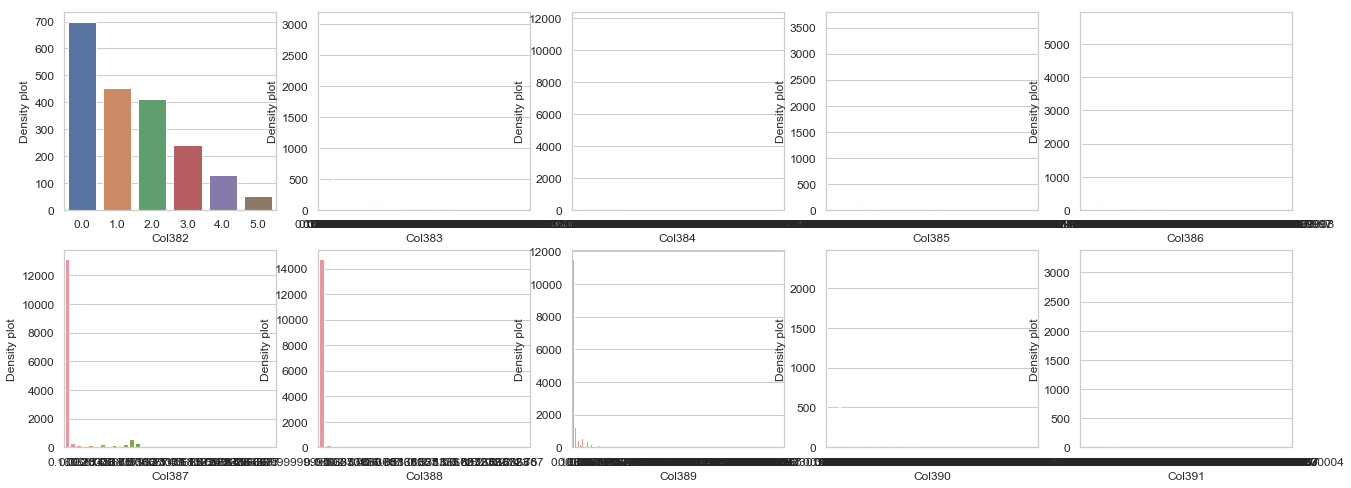

Printing from 180 to 190


<Figure size 432x288 with 0 Axes>

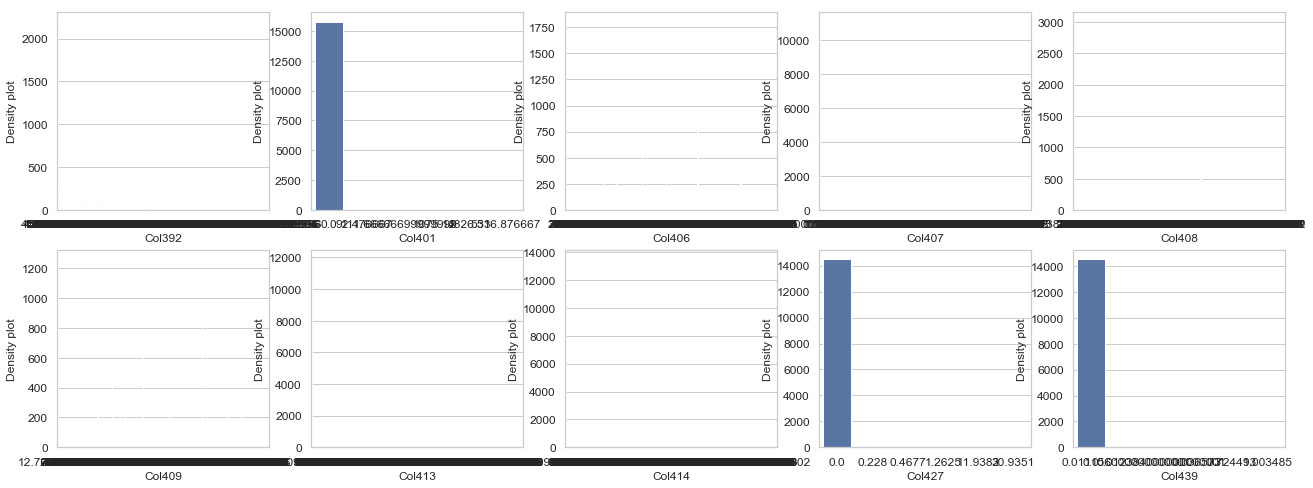

Printing from 190 to 200


<Figure size 432x288 with 0 Axes>

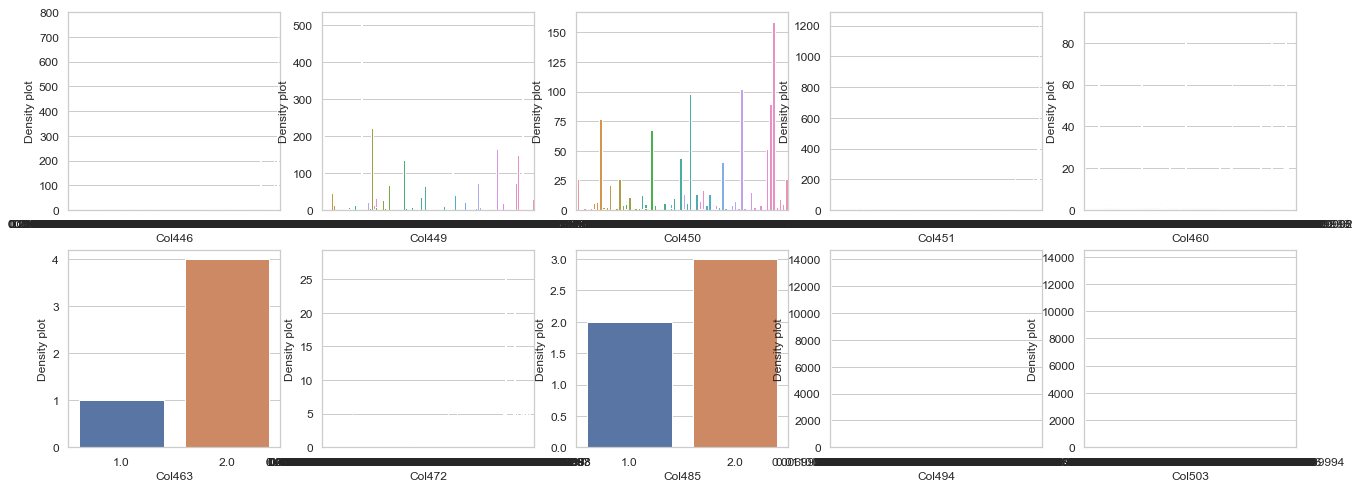

In [67]:
for i in range(10,20):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

In [ ]:
143, 148, 154, 159, 182, 184 [120-140]

train['Col32'].value_counts()

In [68]:
def plot_cat_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.countplot(t1[feature],label="cls: 1")
        sns.countplot(t0[feature],label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
# for i in range(10):
#     print("Printing from {} to {}".format(i*10, (i+1)*10))
#     plot_distribution(cat_cols[i*10:(i+1)*10])

In [69]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna(),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()


Printing from 100 to 110


<Figure size 432x288 with 0 Axes>

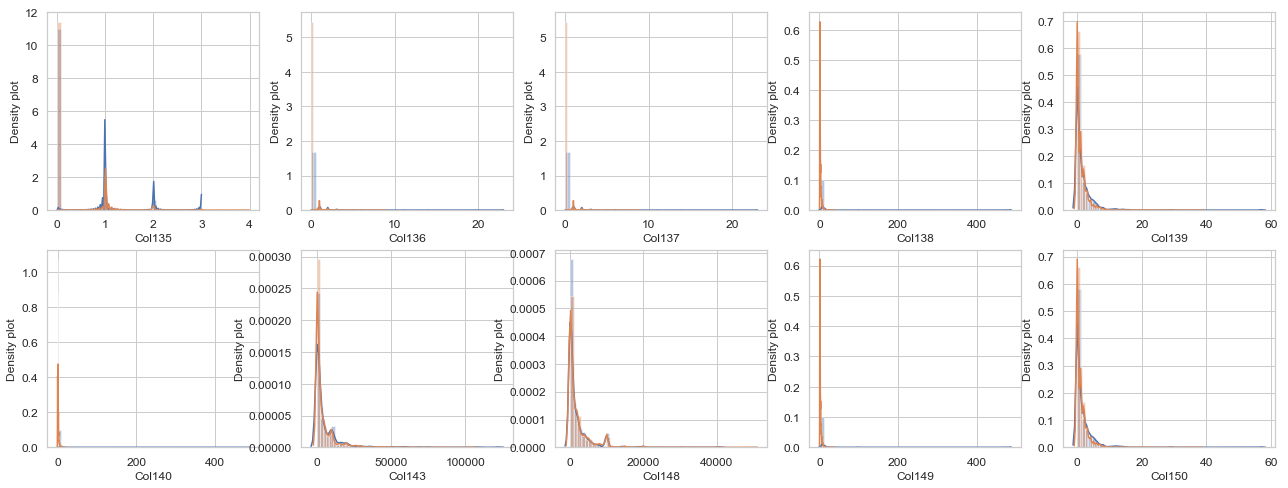

Printing from 110 to 120


<Figure size 432x288 with 0 Axes>

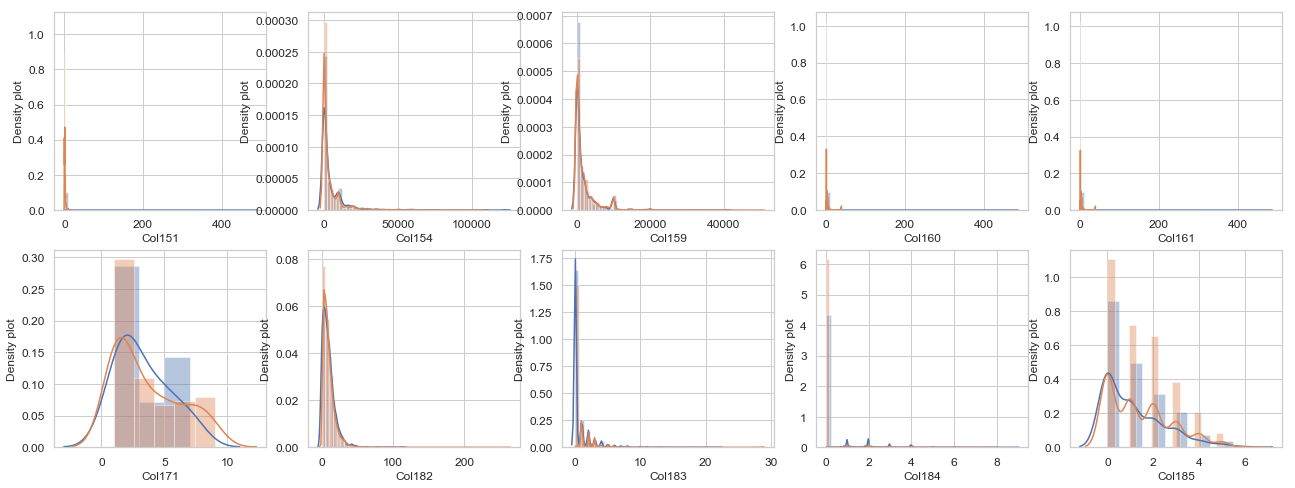

Printing from 120 to 130


<Figure size 432x288 with 0 Axes>

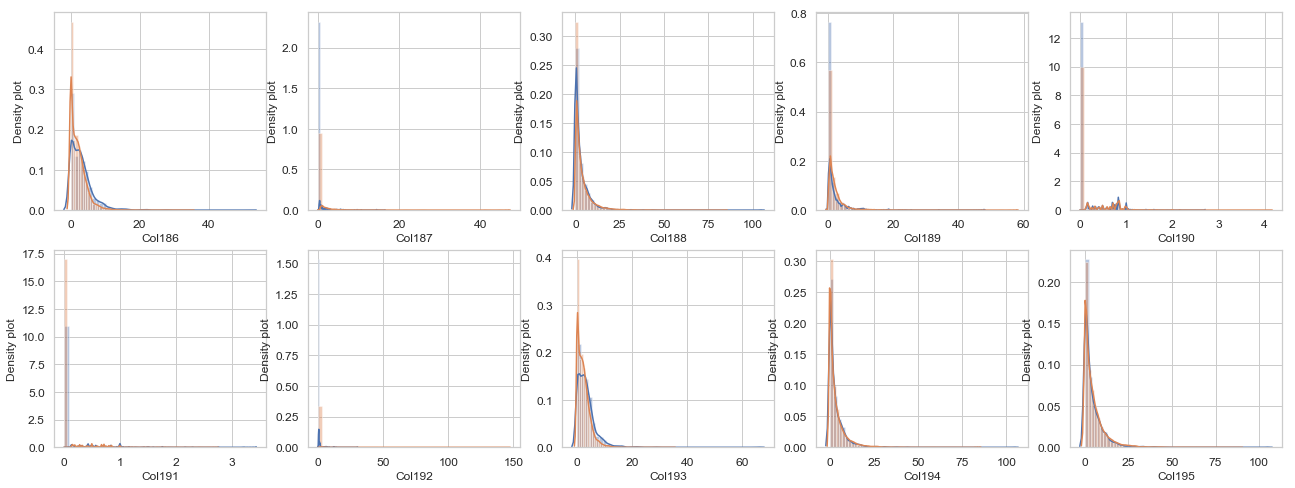

Printing from 130 to 140


<Figure size 432x288 with 0 Axes>

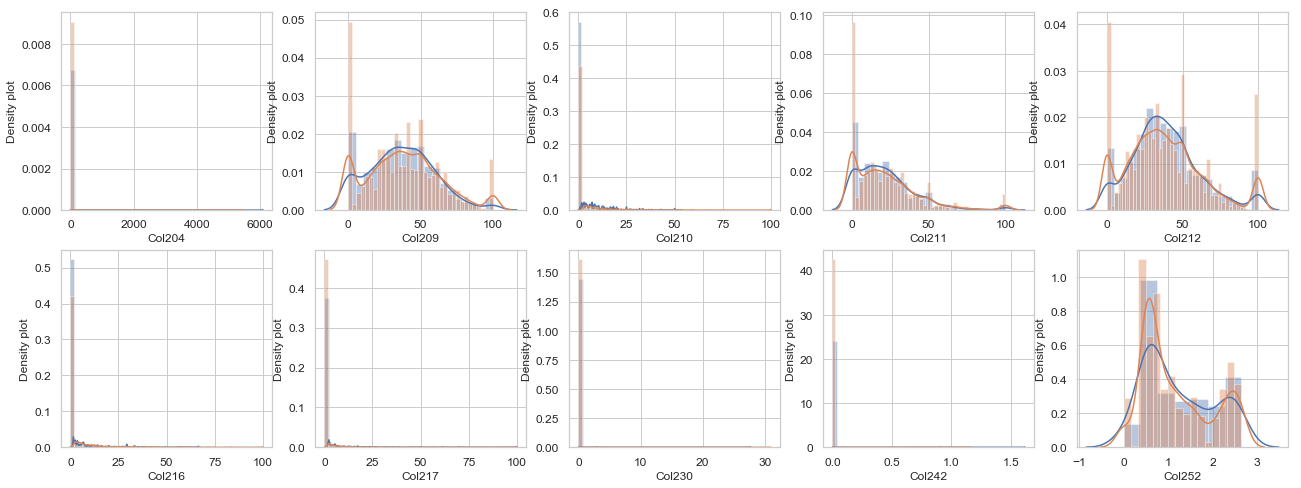

Printing from 140 to 150


<Figure size 432x288 with 0 Axes>

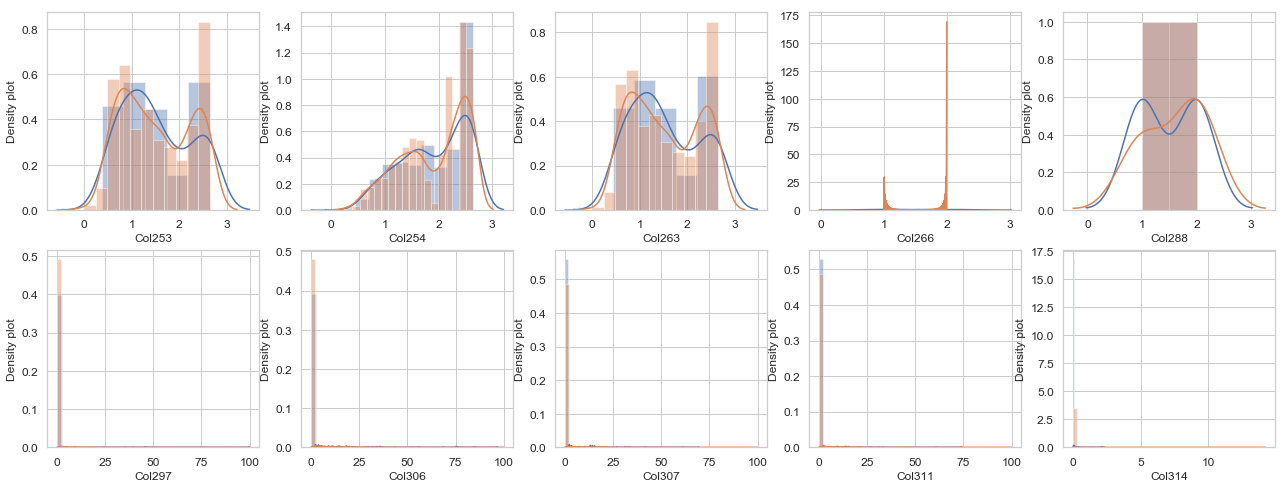

Printing from 150 to 160


<Figure size 432x288 with 0 Axes>

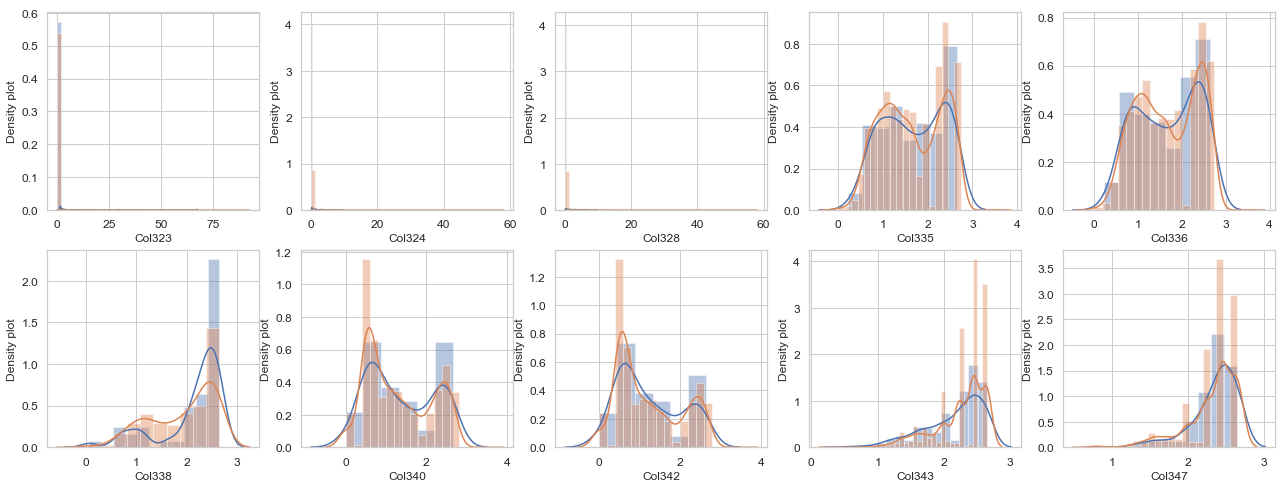

Printing from 160 to 170


<Figure size 432x288 with 0 Axes>

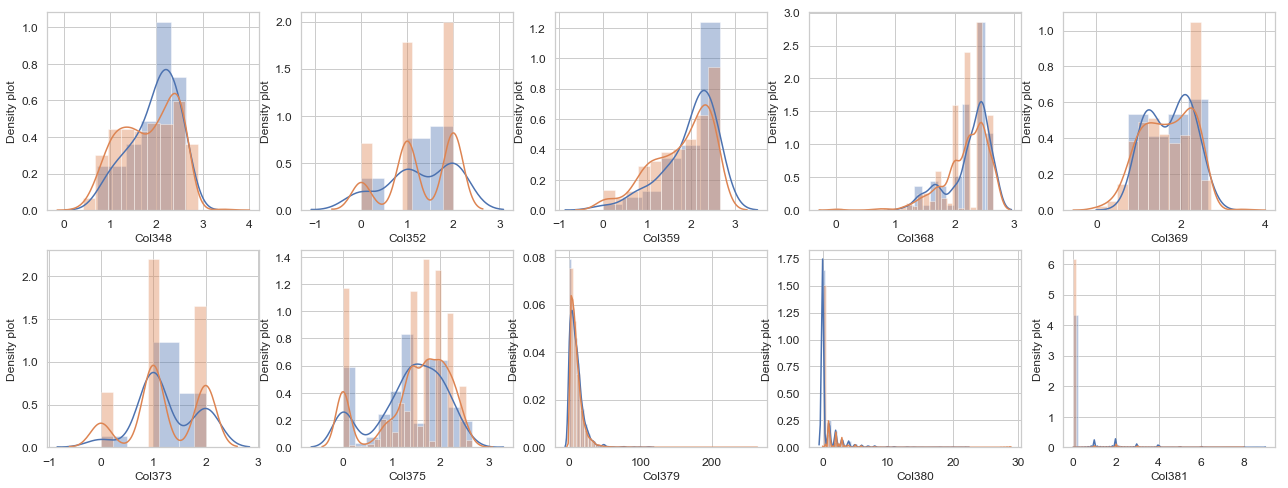

Printing from 170 to 180


<Figure size 432x288 with 0 Axes>

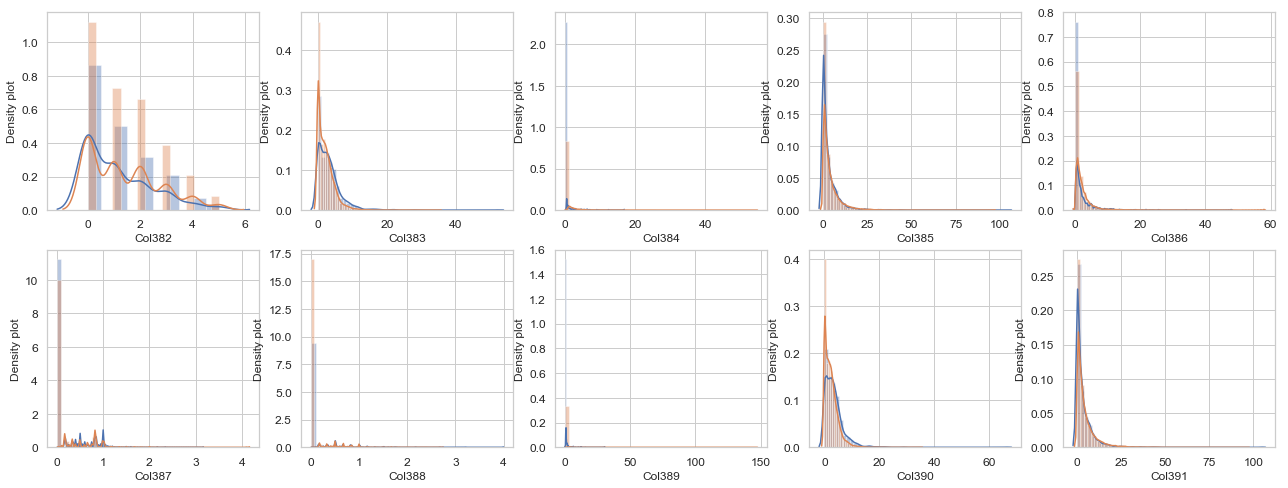

Printing from 180 to 190


<Figure size 432x288 with 0 Axes>

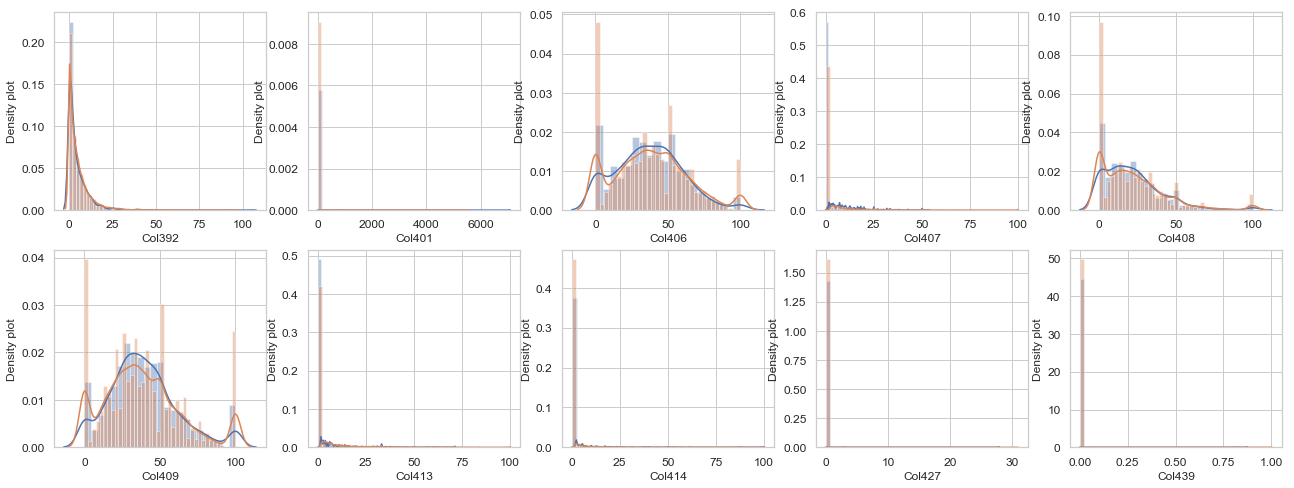

Printing from 190 to 200


<Figure size 432x288 with 0 Axes>

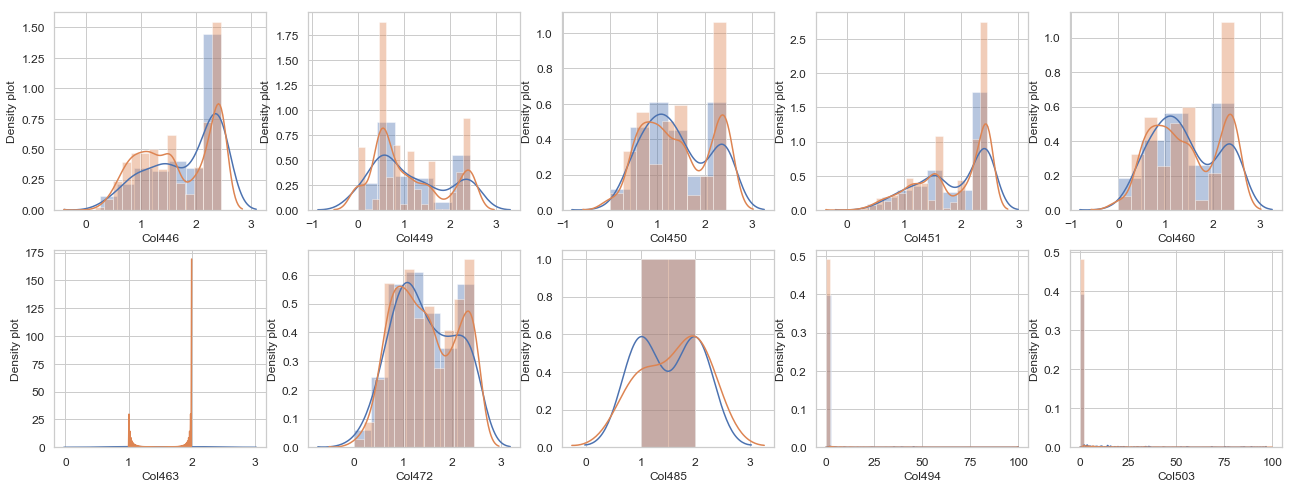

In [70]:
for i in range(10,20):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(cat_cols[i*10:(i+1)*10])

In [73]:
import statsmodels as sm

sm.OLS(target, train)

AttributeError: module 'statsmodels' has no attribute 'OLS'

In [74]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Generate artificial data (2 regressors + constant)
nobs = 100 
X = np.random.random((nobs, 2)) 
X = sm.add_constant(X)
beta = [1, .1, .5] 
e = np.random.random(nobs)
y = np.dot(X, beta) + e 

# Fit regression model
print(sm.OLS(y, X).fit().params)

print(LinearRegression(fit_intercept=False).fit(X, y).coef_)

[1.46810215 0.21360706 0.45045609]
[1.46810215 0.21360706 0.45045609]


In [75]:
ols = sm.OLS(target, sm.add_constant(train)).fit()

MissingDataError: exog contains inf or nans

In [76]:
LinearRegression(fit_intercept=False).fit(train, target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:
train[num_cols[-100:]].isnull().sum()

Col761     2613
Col762     2542
Col765     2171
Col766     2551
Col767    11485
Col769    12688
Col770    11050
Col771     1044
Col772     1147
Col773     1921
Col774    11838
Col775     2611
Col776     5129
Col777    13275
Col778    14973
Col779    11428
Col780     1192
Col781     2202
Col782     1067
Col783     1929
Col784    11838
Col785     2620
Col786     5130
Col787    10732
Col788    14973
Col789     2598
Col790    11428
Col792     1195
Col793     2208
Col794     1068
Col795     3318
Col796    13235
Col797     4008
Col798     6526
Col802     2589
Col803     3599
Col804     2464
Col805     3326
Col806    13235
Col807     4017
Col808     6527
Col809    12129
Col811     3995
Col812    12825
Col814     2592
Col815     3605
Col816     2465
Col817     4008
Col818     6347
Col819    12912
Col820    14112
Col821     4017
Col823    14265
Col825     6347
Col828    13367
Col829     4017
Col830     3946
Col833     3576
Col834     3954
Col835    12912
Col837    14112
Col838     2611
Col839  

Printing from 0 to 10


ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 0 Axes>

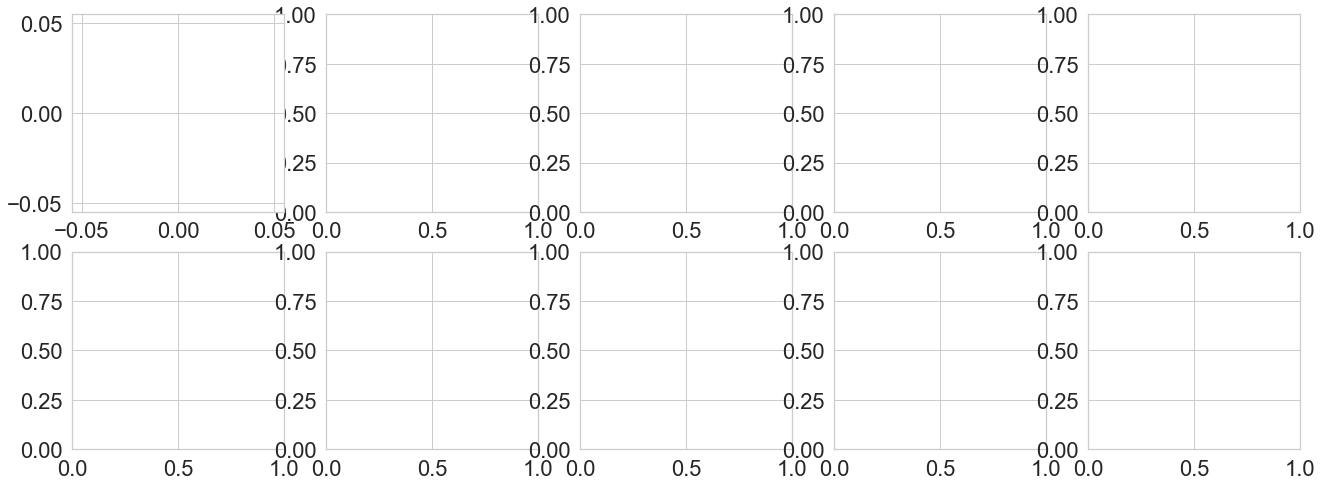

In [51]:
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[target != 0]
    t0 = train.loc[target == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(22,8))

    for feature in var:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(t1[feature].dropna().apply(np.log),label="cls: 1")
        sns.distplot(t0[feature].dropna(),label="cls: 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    
    
for i in range(10):
    print("Printing from {} to {}".format(i*10, (i+1)*10))
    plot_distribution(num_cols[i*10:(i+1)*10])

In [12]:
oof_cat1

array([0.33073674, 0.11057386, 0.16114838, ..., 0.20314675, 0.08511239,
       0.29220203])

In [13]:
# predi_cat1

In [14]:
# np.mean(predi_cat1, axis=1)

In [15]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat1, axis=1)]
# y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]

sub_cat1 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat1.columns = ['Col1','Col2']
sub_cat1

Col1  Col2
0      RIGD58ZWD   0.0
1      RIH660YDS   0.0
2      RIH660Q96   0.0
3      RIYDO15W1   0.0
4      RIYBGC1ZD   0.0
5      RIYBQ5SWR   0.0
6      RIYBQ5SD5   0.0
7       TI5HU5XY   0.0
8       TIYHGOSE   0.0
9       T90K61QJ   0.0
10      T7VUCSYG   0.0
11      T10BV81R   0.0
12      T1EWVOZZ   0.0
13      TDYO6BYZ   0.0
14      TDY6VY5E   0.0
15      TYWOUOSR   0.0
16      TYGRLBSY   0.0
17      TYE6VOKZ   1.0
18      TSW65YKE   0.0
19      TS5HVY1Z   0.0
20       TSMKICK   0.0
21      T25ROOSG   0.0
22      99LRCY1W   0.0
23      99YKLSZ5   0.0
24      970WOYQY   0.0
25      97MKU1NG   0.0
26      9LWB6C1J   0.0
27      9L5BQC15   0.0
28      9DMD5CKW   0.0
29      9Y0IVBQZ   0.0
30      9YM6QCYG   0.0
31      9S5HOY59   0.0
32      9SH6IS1Z   0.0
33      9SYK65SD   0.0
34      92GB5SN5   0.0
35      92GR5O4E   0.0
36      92HHL54D   0.0
37      92YBQMNW   0.0
38      92EUCSSZ   0.0
39      9NLDCC4D   0.0
40      9N5ICBZ5   0.0
41      9NMWI049   0.0
42      9NHDCSYD   1.0
43      AILK58QW   0.0
44      AIWWOYXE   0.0
45      AIWRGO1Z   0.0
46      AIGBVONY   1.0
47      AI5R5BZY   0.0
48      AI5HQ04Y   0.0
49      AIMILB1J   0.0
50      AIHROO1E   0.0
51      AIEH5BN5   0.0
52      A9LI5OXD   0.0
53      A9WBQCND   0.0
54      A9GHC5KR   0.0
55      A9HRL8YG   0.0
56      A9HUC8NJ   0.0
57      A9YBV55Y   1.0
58      A7VRQCKE   0.0
59       A7LHQ8Y   0.0
60      A7WIIY4G   0.0
61      A70BC0QZ   0.0
62      A7MR5M4W   0.0
63       A7HRUYZ   0.0
64      A7YDO0KR   0.0
65      A7YRVOKZ   0.0
66      A1VBCYNW   1.0
67      A1WDLMKZ   1.0
68      A1WU6YKJ   0.0
69      A1HIG0Z5   0.0
70      A1HBV01E   0.0
71      A1EROC55   0.0
72      ALLWIO49   0.0
73      ALWKI0YG   1.0
74      ALMKCBXE   0.0
75      ADVDOOXY   0.0
76      ADVW5SNE   0.0
77      ADL6U5QW   0.0
78      AD5KGOYR   0.0
79      ADMI6SZ5   0.0
80      ADMU55YJ   0.0
81      ADM65Y4G   0.0
82      ADHWQBQZ   0.0
83      ADYW51QW   0.0
84      ADED60KR   0.0
85      AYWRQMY5   0.0
86      AYGIG85E   0.0
87      AYGBUCNE   0.0
88      AY5BGCKJ   0.0
89      ASVRGCN9   0.0
90      ASWBCCSJ   0.0
91      AS5OQYNJ   0.0
92      AS5HQCZY   0.0
93      ASHOV5XZ   1.0
94      ASHHO81Y   0.0
95      A2LKCOQ5   1.0
96      A20UI01E   0.0
97      A2MUGSXJ   0.0
98      A2EHL145   0.0
99      ANVKQ01J   0.0
...          ...   ...
20342   OLWUO05G   0.0
20343   OLWUCCYD   0.0
20344   OLWUIY45   0.0
20345   OLWUIYZ9   0.0
20346   OLWUI1N5   0.0
20347   OLWUVYZJ   0.0
20348   OLWU5OZZ   0.0
20349   OLWU50SY   0.0
20350   OLWU51XR   0.0
20351   OLW6GBQZ   0.0
20352   OLW6L1YZ   0.0
20353   OLW6U559   0.0
20354   OLW6USXW   0.0
20355   OLW6USKR   0.0
20356   OLW6Q01J   0.0
20357   OLW6Q0KZ   0.0
20358   OLW66YSJ   0.0
20359   OLW66C5Z   0.0
20360   OLW6OY1W   0.0
20361   OLW6OC1D   0.0
20362   OLW6COSR   0.0
20363   OLW6CSYE   0.0
20364   OLW6CYSD   1.0
20365   OLW6I555   0.0
20366   OLW6V1QW   0.0
20367   OLW65MZJ   0.0
20368   OLW65O1Z   0.0
20369   OLWHGSYY   0.0
20370   OLWHUSNJ   0.0
20371   OLWHU01J   0.0
20372   OLWHU0K5   0.0
20373   OLWHU1Z5   0.0
20374   OLWH6CNR   0.0
20375   OLWH61KD   0.0
20376   OLWHO1YE   0.0
20377   OLWHIM1W   0.0
20378   OLWHI8ND   0.0
20379   OLWHVYSG   0.0
20380   OLWHV15E   0.0
20381   OLWH5MSJ   0.0
20382   OLWH58XZ   0.0
20383   OLWH5S4G   0.0
20384   OLWH5SSZ   0.0
20385   OL0KGB4Z   0.0
20386   OL0KLBXR   0.0
20387   OL0KL5Y5   0.0
20388   OL0KU8XG   0.0
20389   OL0KU5NG   0.0
20390   OL0KQBSJ   0.0
20391   OL0KQ5XJ   0.0
20392   OL0KQ0NG   0.0
20393   OL0K6S5Y   0.0
20394   OL0KO54G   0.0
20395   OL0KO5QW   0.0
20396   OL0KOSSJ   0.0
20397   OL0KCC19   0.0
20398   OL0KISQD   0.0
20399   OL0KICY9   0.0
20400   OL0KVMKR   0.0
20401   OL0KV8Y9   0.0
20402   OL0KVOQY   0.0
20403   OL0KV5NW   0.0
20404   OL0KV5SW   0.0
20405   OL0KV5SZ   0.0
20406   OL0KVS1G   0.0
20407   OL0K5YNJ   0.0
20408   OL0DLBYJ   0.0
20409   OL0DUMQ9   0.0
20410   OL0DQO5J   0.0
20411   OL0D68NW   0.0
20412   OL0DIMYR   0.0
20413   OL0DIY4Y   0.0
20414   OL

In [16]:
no_imp_cat1 = imp_cat1[imp_cat1.imp == 0]['feature'].values

In [41]:
import pandas as pd
import numpy as np
import os, gc
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from hyperopt import hp, tpe, fmin, Trials



def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        features: training features
    Return:
        oof-pred, model
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=False,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]

    return oof, clf


def run_hyperopt_cat(train_df, target, max_evals):

    def bayesian_opt(params):
        
        params['depth'] = int(params['depth'])
        n_splits = 4
        random_seed = 1234

        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        oof_cat = np.zeros(len(train_df))
        score_cv = []

        ##########################
        for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):

            y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
            features = X_train.columns

            num_rounds = 10000
            oof, clf = train_cat_model(X_train, y_train, 
                                       X_valid, y_valid, 
                                       features, params, 
                                       num_rounds)

            oof_cat[valid_index] = oof
#             score = roc_auc_score(y_valid, oof)
#             score_cv.append(score)
    
#             score = roc_auc_score(y_valid, oof)
#             print( "  auc = ", score )
            y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
            score = f1_score(y_valid, y_bin, average='weighted')
#             print( "  f1 = ", score )
            score_cv.append(score)
#             print("="*60)
            gc.collect()
        
        
        
#         print(np.round(np.mean(score_cv), 4))
#         print( "  cv-auc = ", np.round(np.mean(score_cv), 4),'+/-', np.std(score_cv) )
        return -np.mean(score_cv)
    
    
    bayesian_params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : hp.quniform('random_strength', 1, 6, 0.2),
        'border_count'          : 128,
        'scale_pos_weight'      : 8.9,#3.507,
        'depth'                 : hp.quniform('depth', 4, 7, 1),
        #hp.choice('depth', [4,5,6,7]), 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
        # subsample can't be used, while bootstrap (bayesian) is used.
#         'subsample'             : hp.quniform('subsample', 0.3, 0.8, 0.1), 
#         'iterations'            : 10000, 
        'learning_rate'         : hp.quniform('learning_rate',0.01, 0.1, 0.001),
        'thread_count'          : 4,
        'l2_leaf_reg'           : hp.uniform('l2_leaf_reg', 0.1, 5.0),#3,
#         'grow_policy'           : hp.choice('grow_policy', 
#                                             ['SymmetricTree', 'Depthwise', 'Lossguide']),
#         'min_data_in_leaf'      : hp.choice('min_data_in_leaf', np.arange(50, 150, 5)),
        
#         hp.choice('min_data_in_leaf', [
#             {'grow_policy': 'SymmetricTree', 'min_data_in_leaf': None},
#             {'grow_policy': ['Depthwise', 'Lossguide'], 
#              'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(50, 150, 5))},
#             ])
    }
     
    
    trials = Trials()
    results = fmin(bayesian_opt, bayesian_params, algo=tpe.suggest, 
                   trials=trials, max_evals=max_evals)
        
    return results, trials 



In [42]:
# clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=4)
results, trials = run_hyperopt_cat(train.drop(no_imp_cat1, axis=1), target, max_evals=100)

100%|██████████| 100/100 [11:30:57<00:00, 319.60s/it, best loss: -0.7720095478599176] 


In [44]:
results

{'depth': 7.0,
 'l2_leaf_reg': 3.0753960899722625,
 'learning_rate': 0.063,
 'random_strength': 3.8000000000000003}

In [50]:
train.drop(no_imp_cat1, axis=1).shape, test.drop(no_imp_cat1, axis=1).shape

((17521, 1428), (20442, 1428))

In [58]:
imp_cat1[imp_cat1.imp == 0]['feature'].values

array(['Col2078', 'Col1958', 'Col1956', 'Col1953', 'Col1952', 'Col1951',
       'Col1949', 'Col1948', 'Col1947', 'Col1946', 'Col1945', 'Col1942',
       'Col820', 'Col1939', 'Col1938', 'Col1935', 'Col1961', 'Col1962',
       'Col1964', 'Col1965', 'Col1999', 'Col1998', 'Col1996', 'Col812',
       'Col813', 'Col1991', 'Col1985', 'Col1934', 'Col1981', 'Col1979',
       'Col1977', 'Col1976', 'Col1975', 'Col1972', 'Col1971', 'Col1966',
       'Col1980', 'Col1933', 'Col821', 'Col1928', 'Col1884', 'Col829',
       'Col1876', 'Col1874', 'Col1869', 'Col1868', 'Col833', 'Col1885',
       'Col1866', 'Col1863', 'Col1862', 'Col1861', 'Col1860', 'Col1857',
       'Col1850', 'Col1848', 'Col1864', 'Col200', 'Col1886', 'Col1890',
       'Col1923', 'Col1922', 'Col1920', 'Col825', 'Col1917', 'Col1913',
       'Col1912', 'Col1888', 'Col1909', 'Col1905', 'Col1903', 'Col1901',
       'Col1900', 'Col190', 'Col1899', 'Col1897', 'Col1906', 'Col2000',
       'Col2001', 'Col2003', 'Col2104', 'Col2103', 'Col2102'

In [61]:
np.equal(no_imp_cat1, imp_cat1[imp_cat1.imp == 0]['feature'].values).sum(), len(no_imp_cat1)

(963, 963)

In [71]:
clf_cat3, imp_cat3, oof_cat3, predi_cat3 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=5)


(13140,) (4381,)
Fold 0
0:	test: 0.6474857	test1: 0.6395844	best: 0.6395844 (0)	total: 178ms	remaining: 29m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7176254935
bestIteration = 19

Shrink model to first 20 iterations.
  auc =  0.7176254935138183
  f1 =  0.8654814760329295
(13141,) (4380,)
Fold 1
0:	test: 0.5558767	test1: 0.5419858	best: 0.5419858 (0)	total: 270ms	remaining: 44m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7181847024
bestIteration = 32

Shrink model to first 33 iterations.
  auc =  0.7181847023534841
  f1 =  0.8574206518557851
(13141,) (4380,)
Fold 2
0:	test: 0.5968266	test1: 0.5780734	best: 0.5780734 (0)	total: 256ms	remaining: 42m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7175963313
bestIteration = 9

Shrink model to first 10 iterations.
  auc =  0.7175963313336409
  f1 =  0.8600050454457503
(13141,) (4380,)
Fold 3
0:	test: 0.5603114	test1: 0.5551791	best: 0.5551791 (0)	total: 239ms

In [72]:
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     15760
           1       0.30      0.25      0.27      1761

   micro avg       0.87      0.87      0.87     17521
   macro avg       0.61      0.59      0.60     17521
weighted avg       0.86      0.87      0.86     17521



In [52]:
ybins = [1.0 if y > 0.5 else 0 for y in oof_cat3]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     15760
           1       0.27      0.25      0.26      1761

   micro avg       0.86      0.86      0.86     17521
   macro avg       0.59      0.59      0.59     17521
weighted avg       0.85      0.86      0.85     17521



In [67]:
ybins = [1.0 if y > 0.5 else 0 for y in np.mean(predi_cat3, axis=1)]
# y_bin = [1. if y_cont > 0.5 else 0. for y_cont in oof]
del sub_cat1
gc.collect()
sub_cat3 = pd.DataFrame(data=pd.concat([ts_ids.reset_index(drop=True), pd.DataFrame(ybins)], axis=1))
sub_cat3.columns = ['Col1','Col2']
sub_cat3

Col1  Col2
0      RIGD58ZWD   0.0
1      RIH660YDS   0.0
2      RIH660Q96   0.0
3      RIYDO15W1   0.0
4      RIYBGC1ZD   0.0
5      RIYBQ5SWR   1.0
6      RIYBQ5SD5   0.0
7       TI5HU5XY   0.0
8       TIYHGOSE   0.0
9       T90K61QJ   0.0
10      T7VUCSYG   0.0
11      T10BV81R   0.0
12      T1EWVOZZ   0.0
13      TDYO6BYZ   0.0
14      TDY6VY5E   0.0
15      TYWOUOSR   0.0
16      TYGRLBSY   0.0
17      TYE6VOKZ   1.0
18      TSW65YKE   0.0
19      TS5HVY1Z   0.0
20       TSMKICK   0.0
21      T25ROOSG   0.0
22      99LRCY1W   0.0
23      99YKLSZ5   0.0
24      970WOYQY   0.0
25      97MKU1NG   0.0
26      9LWB6C1J   0.0
27      9L5BQC15   0.0
28      9DMD5CKW   0.0
29      9Y0IVBQZ   0.0
30      9YM6QCYG   0.0
31      9S5HOY59   0.0
32      9SH6IS1Z   0.0
33      9SYK65SD   0.0
34      92GB5SN5   0.0
35      92GR5O4E   0.0
36      92HHL54D   0.0
37      92YBQMNW   0.0
38      92EUCSSZ   0.0
39      9NLDCC4D   0.0
40      9N5ICBZ5   0.0
41      9NMWI049   0.0
42      9NHDCSYD   1.0
43      AILK58QW   0.0
44      AIWWOYXE   0.0
45      AIWRGO1Z   0.0
46      AIGBVONY   1.0
47      AI5R5BZY   0.0
48      AI5HQ04Y   0.0
49      AIMILB1J   0.0
50      AIHROO1E   0.0
51      AIEH5BN5   0.0
52      A9LI5OXD   0.0
53      A9WBQCND   0.0
54      A9GHC5KR   0.0
55      A9HRL8YG   0.0
56      A9HUC8NJ   0.0
57      A9YBV55Y   1.0
58      A7VRQCKE   0.0
59       A7LHQ8Y   0.0
60      A7WIIY4G   0.0
61      A70BC0QZ   0.0
62      A7MR5M4W   0.0
63       A7HRUYZ   0.0
64      A7YDO0KR   0.0
65      A7YRVOKZ   0.0
66      A1VBCYNW   1.0
67      A1WDLMKZ   1.0
68      A1WU6YKJ   0.0
69      A1HIG0Z5   0.0
70      A1HBV01E   0.0
71      A1EROC55   0.0
72      ALLWIO49   0.0
73      ALWKI0YG   1.0
74      ALMKCBXE   0.0
75      ADVDOOXY   0.0
76      ADVW5SNE   0.0
77      ADL6U5QW   0.0
78      AD5KGOYR   0.0
79      ADMI6SZ5   0.0
80      ADMU55YJ   0.0
81      ADM65Y4G   0.0
82      ADHWQBQZ   0.0
83      ADYW51QW   0.0
84      ADED60KR   0.0
85      AYWRQMY5   0.0
86      AYGIG85E   0.0
87      AYGBUCNE   0.0
88      AY5BGCKJ   0.0
89      ASVRGCN9   0.0
90      ASWBCCSJ   0.0
91      AS5OQYNJ   0.0
92      AS5HQCZY   0.0
93      ASHOV5XZ   1.0
94      ASHHO81Y   0.0
95      A2LKCOQ5   1.0
96      A20UI01E   0.0
97      A2MUGSXJ   0.0
98      A2EHL145   0.0
99      ANVKQ01J   0.0
...          ...   ...
20342   OLWUO05G   0.0
20343   OLWUCCYD   0.0
20344   OLWUIY45   0.0
20345   OLWUIYZ9   0.0
20346   OLWUI1N5   0.0
20347   OLWUVYZJ   0.0
20348   OLWU5OZZ   0.0
20349   OLWU50SY   0.0
20350   OLWU51XR   0.0
20351   OLW6GBQZ   0.0
20352   OLW6L1YZ   0.0
20353   OLW6U559   0.0
20354   OLW6USXW   0.0
20355   OLW6USKR   0.0
20356   OLW6Q01J   0.0
20357   OLW6Q0KZ   0.0
20358   OLW66YSJ   0.0
20359   OLW66C5Z   0.0
20360   OLW6OY1W   0.0
20361   OLW6OC1D   0.0
20362   OLW6COSR   0.0
20363   OLW6CSYE   0.0
20364   OLW6CYSD   0.0
20365   OLW6I555   0.0
20366   OLW6V1QW   0.0
20367   OLW65MZJ   0.0
20368   OLW65O1Z   0.0
20369   OLWHGSYY   0.0
20370   OLWHUSNJ   0.0
20371   OLWHU01J   0.0
20372   OLWHU0K5   0.0
20373   OLWHU1Z5   0.0
20374   OLWH6CNR   0.0
20375   OLWH61KD   0.0
20376   OLWHO1YE   0.0
20377   OLWHIM1W   0.0
20378   OLWHI8ND   0.0
20379   OLWHVYSG   0.0
20380   OLWHV15E   0.0
20381   OLWH5MSJ   0.0
20382   OLWH58XZ   0.0
20383   OLWH5S4G   0.0
20384   OLWH5SSZ   0.0
20385   OL0KGB4Z   0.0
20386   OL0KLBXR   0.0
20387   OL0KL5Y5   0.0
20388   OL0KU8XG   0.0
20389   OL0KU5NG   0.0
20390   OL0KQBSJ   0.0
20391   OL0KQ5XJ   0.0
20392   OL0KQ0NG   0.0
20393   OL0K6S5Y   0.0
20394   OL0KO54G   0.0
20395   OL0KO5QW   0.0
20396   OL0KOSSJ   0.0
20397   OL0KCC19   0.0
20398   OL0KISQD   0.0
20399   OL0KICY9   0.0
20400   OL0KVMKR   0.0
20401   OL0KV8Y9   0.0
20402   OL0KVOQY   0.0
20403   OL0KV5NW   0.0
20404   OL0KV5SW   0.0
20405   OL0KV5SZ   0.0
20406   OL0KVS1G   0.0
20407   OL0K5YNJ   0.0
20408   OL0DLBYJ   0.0
20409   OL0DUMQ9   0.0
20410   OL0DQO5J   0.0
20411   OL0D68NW   0.0
20412   OL0DIMYR   0.0
20413   OL0DIY4Y   0.0
20414   OL

In [66]:
np.bincount(sub_cat1['Col2'].astype('int'))

array([18796,  1646])

In [70]:
sub_cat3.to_csv('predictions/sub_cat_with_tuning.csv', index=None)

In [17]:
np.bincount(target)

array([15760,  1761])

In [69]:
15760/1761, 18796/1646

(8.94946053378762, 11.419198055893075)

In [ ]:
import time
for col in imp_cat3.tail(50)['feature'].values:
    plt.figure(figsize=(16,5))
    try:
        sns.distplot(train[col])
        sns.distplot(test[col])
    except:
        sns.countplot(train[col])
        sns.countplot(test[col])
    time.sleep(1)

In [19]:
sub_cat1.to_csv('predictions/sub_cat1.csv', index=None)

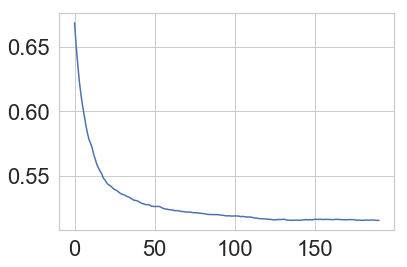

In [29]:
plt.plot(clf_cat1[0].evals_result_['validation_1']['Logloss'])

In [46]:
no_imp_cat1 = imp_cat1[imp_cat1.imp == 0]['feature'].values
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=4)


(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 132ms	remaining: 21m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 112ms	remaining: 18m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 105ms	remaining: 17m 29s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.868962362504332

In [48]:
from sklearn.metrics import classification_report as cr

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     15760
           1       0.36      0.22      0.27      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.59      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
             precision    recall  f1-score   support

           0       0.92      0.95      0.93     15760
           1       0.36      0.25      0.30      1761

   micro avg       0.88      0.88      0.88     17521
   macro avg       0.64      0.60      0.61     17521
weighted avg       0.86      0.88      0.87     17521



In [ ]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train.drop(no_imp_cat1, axis=1), target, test.drop(no_imp_cat1, axis=1), depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

In [8]:
import random, math

def grouping_cols(df, cat_percentage = 0.05, checking_itr = 10):
    cc, nc = [], []
    max_ = 0
    amount = int(df.shape[0]*cat_percentage)
    print(amount, "/", df.shape[0]," Used to differentiate num feature from cat feature")
    for col in df.columns:
        uni = df[col].unique().shape[0]
#         print(uni)
        max_ = max(max_, uni)
        if(uni <= amount):
            cc.append(col)
        else:
            nc.append(col)
        
    print("-----Filtered result after Ist stage-----")
    print("total cat cols: {}, total num cols: {}\n".format(len(cc), len(nc)))
    
    true_cat = []
    true_num = []
    for col in nc+cc:
        num = False
        if(df[col].dtype == 'object'):
            true_cat.append(col)
            continue
        for i in range(checking_itr):
            sample = np.random.choice(df[col].unique())
            if math.isnan(sample): continue
            if int(sample) != sample:
                num = True
        if num is True:
            true_num.append(col)
        else:
            true_cat.append(col)

    print("-----Filtered result after 2nd stage-----")
    print("total cat cols: {}, total num cols: {}".format(len(true_cat), len(true_num)))
    return cc, nc


In [9]:
cat_cols, num_cols = grouping_cols(train, cat_percentage=0.025)


438 / 17521  Used to differentiate num feature from cat feature
-----Filtered result after Ist stage-----
total cat cols: 1725, total num cols: 668

-----Filtered result after 2nd stage-----
total cat cols: 1639, total num cols: 754


In [59]:
# def factorize_cat(table, cat_cols=None):
#     print("=== Factorize Done ====")
#     for col in cat_cols:
#         table[col], _ = pd.factorize(table[col])
#     return table

# df = factorize_cat(df, cat_cols)

In [10]:
train1 = train.drop(no_imp_cat1, axis=1)
test1  = test.drop(no_imp_cat1, axis=1)

new_cat_cols = [col for col in cat_cols if col not in no_imp_cat1]
train1[new_cat_cols] = train1[new_cat_cols].astype("category")
test1[new_cat_cols] = test1[new_cat_cols].astype("category")
train1.shape, test1.shape

NameError: name 'no_imp_cat1' is not defined

In [112]:
gc.collect()

22015

In [61]:
clf_cat1, imp_cat1, oof_cat1, predi_cat1 = run_cv_cat(train1, target, test1, depth=4)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat1]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6511902	test1: 0.6595419	best: 0.6595419 (0)	total: 114ms	remaining: 19m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7430211679
bestIteration = 55

Shrink model to first 56 iterations.
  auc =  0.7430211678580061
  f1 =  0.8740968697108293
(13141,) (4380,)
Fold 1
0:	test: 0.5572453	test1: 0.5582135	best: 0.5582135 (0)	total: 108ms	remaining: 18m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7409797531
bestIteration = 73

Shrink model to first 74 iterations.
  auc =  0.7409797531149054
  f1 =  0.8670481824072024
(13141,) (4380,)
Fold 2
0:	test: 0.6302473	test1: 0.6302247	best: 0.6302247 (0)	total: 117ms	remaining: 19m 31s
200:	test: 0.8071700	test1: 0.7389654	best: 0.7398157 (189)	total: 20.7s	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7408147785
bestIteration = 241

Shrink model to first 242 iterations.
  auc =  0.740814778495616
  f1 =  0.8689623625043329


In [63]:
clf_cat2, imp_cat2, oof_cat2, predi_cat2 = run_cv_cat(train1, target, test1, depth=6)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_cat2]
print(cr(target, ybins))

(13140,) (4381,)
Fold 0
0:	test: 0.6702522	test1: 0.6581558	best: 0.6581558 (0)	total: 268ms	remaining: 44m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7431092234
bestIteration = 127

Shrink model to first 128 iterations.
  auc =  0.7431092233847854
  f1 =  0.8759306910222753
(13141,) (4380,)
Fold 1
0:	test: 0.5655123	test1: 0.5629127	best: 0.5629127 (0)	total: 243ms	remaining: 40m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.744643228
bestIteration = 114

Shrink model to first 115 iterations.
  auc =  0.7446432279649284
  f1 =  0.866465179602157
(13141,) (4380,)
Fold 2
0:	test: 0.6354518	test1: 0.6323102	best: 0.6323102 (0)	total: 322ms	remaining: 53m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7323979003
bestIteration = 32

Shrink model to first 33 iterations.
  auc =  0.7323979003230272
  f1 =  0.8670967317676023
(13141,) (4380,)
Fold 3
0:	test: 0.6570216	test1: 0.6201465	best: 0.6201465 (0)	total: 23

In [66]:
len(new_cat_cols), len(cat_cols)

(892, 1725)

In [68]:
train.shape, train1.shape

((17521, 2393), (17521, 1360))

In [106]:
# train.select_dtypes("category")
# 'Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852'
train['Col702'].value_counts()

0.000000    1395
0.255551       2
0.442620       1
0.079860       1
0.069985       1
0.057143       1
0.058166       1
Name: Col702, dtype: int64

In [111]:
train[['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']].isnull().sum()

Col702    16119
Col733    16979
Col742    16708
Col763    15313
Col791    16117
Col813    17514
Col822    16985
Col831    16744
Col852    15347
dtype: int64

In [110]:
set(no_imp_cat1).intersection(set(['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']))

{'Col763', 'Col813', 'Col822', 'Col831', 'Col852'}

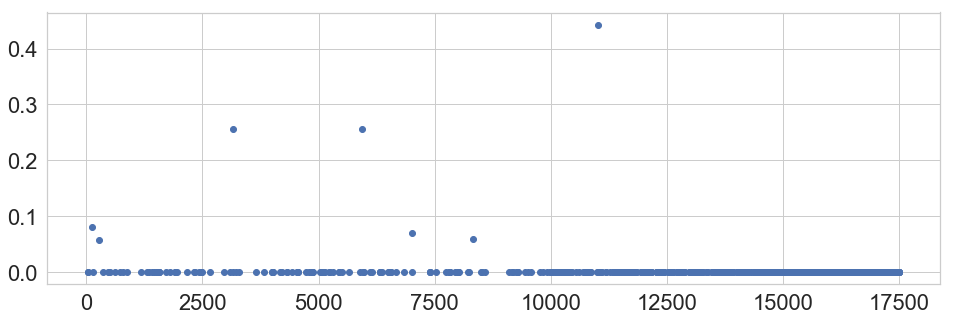

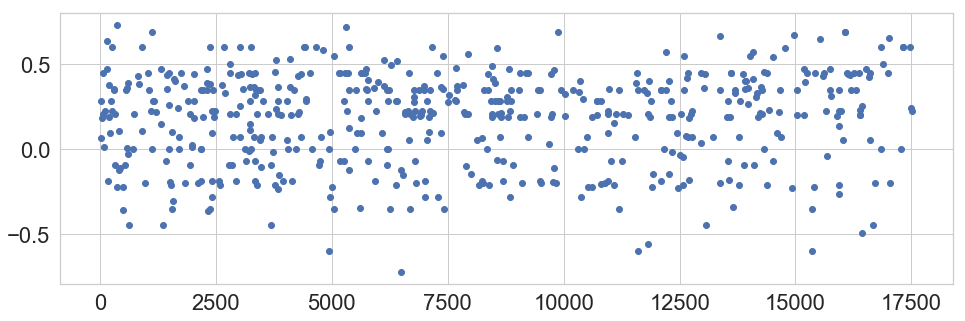

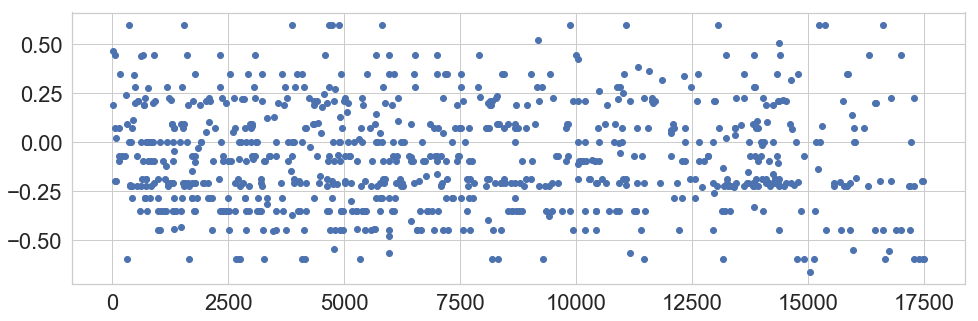

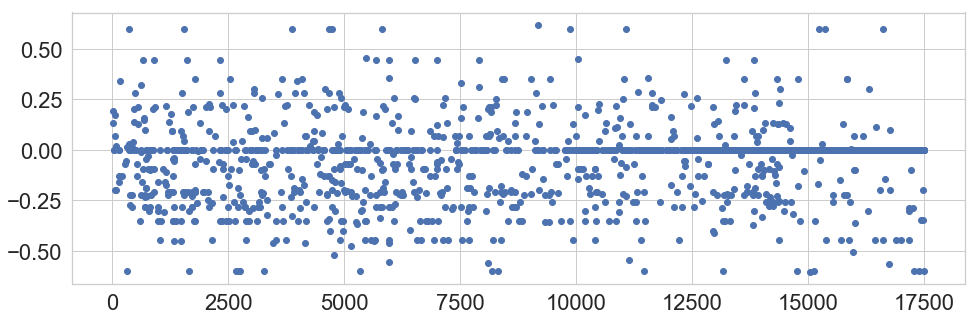

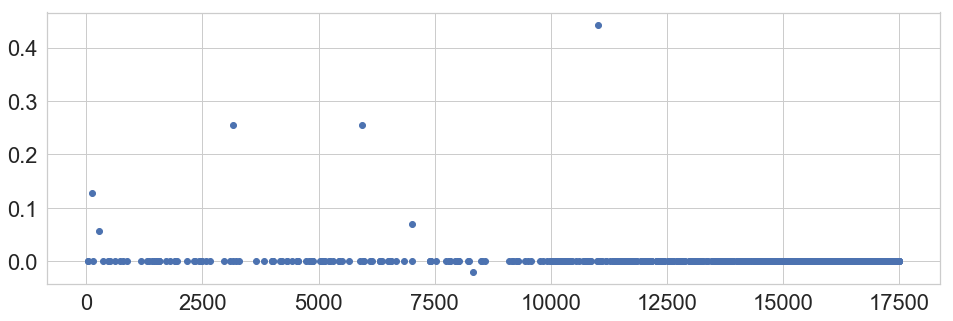

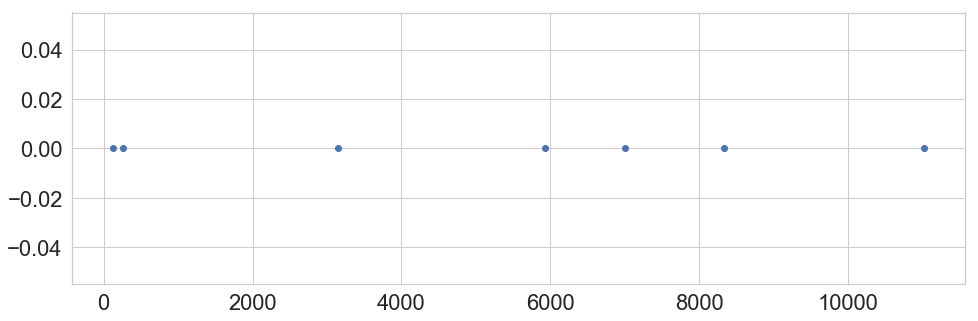

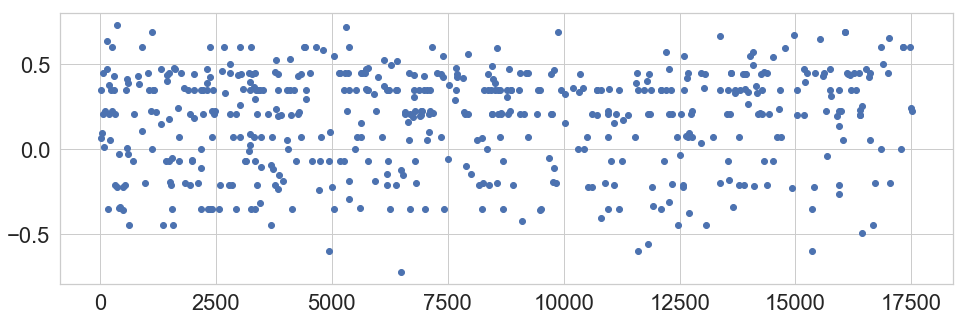

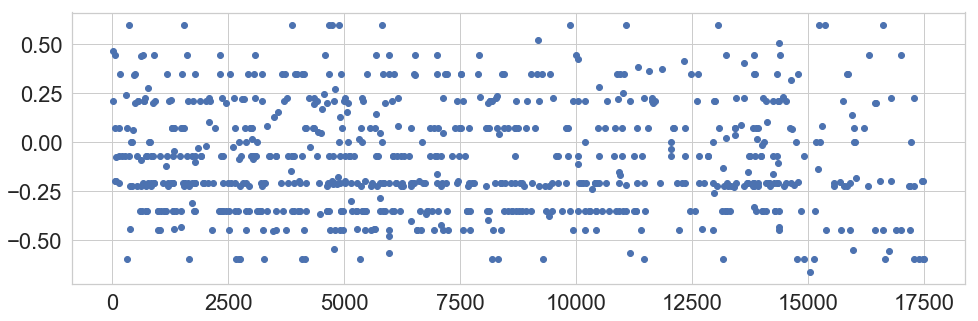

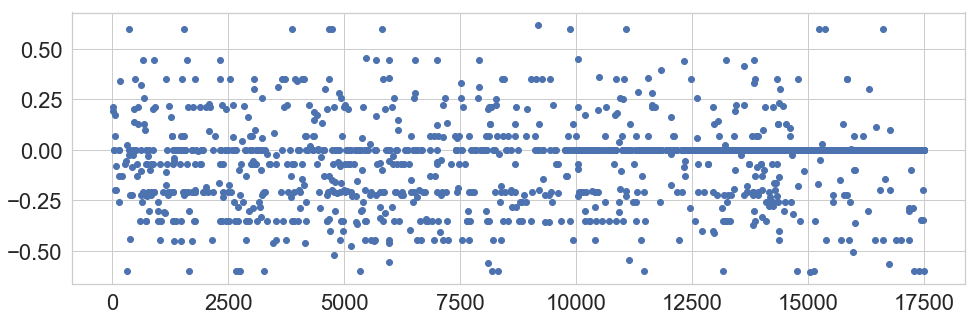

In [109]:
for col in ['Col702', 'Col733', 'Col742', 'Col763', 'Col791', 'Col813', 'Col822', 'Col831', 'Col852']:
    plt.figure(figsize=(16,5))
    plt.plot(train[col],'o')

In [105]:
gc.collect()

422

In [99]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train, target, test, leaves=50)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  50
(13140,) (4381,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[74]	training's auc: 0.800229	valid_1's auc: 0.736953


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col702, Col733, Col742, Col763, Col791, Col813, Col822, Col831, Col852

In [97]:
# train1[new_cat_cols] = train1[new_cat_cols].astype("category")
# test1[new_cat_cols] = test1[new_cat_cols].astype("category")


In [98]:
clf_lgb1, imp_lgb1, oof_lgb1, predi_lgb1 = run_cv_lgb(train1, target, test1, leaves=60)

print("\n\n")
print("="*60)
print("="*60)

ybins = [1.0 if y > 0.5 else 0 for y in oof_lgb1]
print(cr(target, ybins))

using leaves:  60
(13140,) (4381,)
Fold 0


ValueError: DataFrame.dtypes for data must be int, float or bool. Did not expect the data types in fields Col865, Col867, Col868, Col869, Col878, Col879, Col882, Col883, Col887, Col888, Col889, Col890, Col891, Col894, Col895, Col896, Col897, Col898, Col899, Col900, Col903, Col904, Col905, Col906, Col907, Col908, Col909, Col911, Col912, Col913, Col914, Col915, Col917, Col919, Col924, Col927, Col928, Col929, Col930, Col935, Col936, Col938, Col941, Col944, Col946, Col949, Col951, Col952, Col954, Col958, Col959, Col961, Col962, Col963, Col966, Col967, Col970, Col971, Col975, Col977, Col978, Col980, Col982, Col983, Col985, Col989, Col991, Col992, Col993, Col994, Col999, Col1000, Col1001, Col1006, Col1007, Col1008, Col1009, Col1010, Col1012, Col1013, Col1014, Col1015, Col1020, Col1021, Col1028, Col1029, Col1030, Col1032, Col1036, Col1037, Col1038, Col1040, Col1041, Col1042, Col1043, Col1044, Col1046, Col1047, Col1051, Col1053, Col1056, Col1057, Col1059, Col1060, Col1061, Col1062, Col1063, Col1064, Col1065, Col1069, Col1071, Col1074, Col1079, Col1082, Col1084, Col1087, Col1088, Col1089, Col1091, Col1092, Col1093, Col1094, Col1095, Col1097, Col1099, Col1103, Col1106, Col1107, Col1108, Col1109, Col1110, Col1113, Col1114, Col1116, Col1120, Col1121, Col1130, Col1131, Col1132, Col1135, Col1136, Col1137, Col1138, Col1141, Col1143, Col1144, Col1145, Col1146, Col1150, Col1151, Col1152, Col1154, Col1161, Col1162, Col1164, Col1167, Col1168, Col1172, Col1173, Col1174, Col1176, Col1179, Col1180, Col1181, Col1183, Col1184, Col1185, Col1186, Col1187, Col1188, Col1189, Col1192, Col1193, Col1197, Col1198, Col1199, Col1200, Col1202, Col1204, Col1205, Col1207, Col1208, Col1209, Col1211, Col1212, Col1213, Col1215, Col1217, Col1220, Col1222, Col1224, Col1227, Col1229, Col1230, Col1231, Col1232, Col1233, Col1234, Col1236, Col1238, Col1241, Col1242, Col1245, Col1246, Col1249, Col1258, Col1263, Col1266, Col1267, Col1268, Col1272, Col1277, Col1279, Col1281, Col1283, Col1287, Col1288, Col1290, Col1291, Col1292, Col1293, Col1294, Col1299, Col1302, Col1303, Col1304, Col1305, Col1309, Col1310, Col1311, Col1313, Col1315, Col1316, Col1317, Col1319, Col1321, Col1322, Col1330, Col1332, Col1333, Col1339, Col1340, Col1343, Col1344, Col1345, Col1346, Col1349, Col1351, Col1352, Col1354, Col1357, Col1360, Col1363, Col1364, Col1365, Col1367, Col1371, Col1373, Col1374, Col1375, Col1377, Col1380, Col1381, Col1383, Col1385, Col1386, Col1387, Col1389, Col1391, Col1393, Col1394, Col1395, Col1396, Col1398, Col1400, Col1402, Col1403, Col1406, Col1407, Col1408, Col1409, Col1410, Col1412, Col1413, Col1416, Col1418, Col1421, Col1422, Col1423, Col1425, Col1426, Col1428, Col1431, Col1432, Col1433, Col1439, Col1441, Col1442, Col1443, Col1444, Col1450, Col1451, Col1453, Col1454, Col1455, Col1456, Col1459, Col1464, Col1467, Col1469, Col1471, Col1477, Col1478, Col1479, Col1480, Col1485, Col1488, Col1489, Col1491, Col1496, Col1497, Col1498, Col1499, Col1500, Col1502, Col1503, Col1505, Col1506, Col1511, Col1512, Col1518, Col1519, Col1521, Col1522, Col1523, Col1524, Col1525, Col1527, Col1528, Col1531, Col1535, Col1538, Col1540, Col1541, Col1542, Col1544, Col1545, Col1550, Col1551, Col1552, Col1554, Col1556, Col1560, Col1564, Col1566, Col1571, Col1572, Col1573, Col1574, Col1575, Col1576, Col1577, Col1579, Col1581, Col1582, Col1584, Col1585, Col1587, Col1590, Col1592, Col1593, Col1594, Col1597, Col1599, Col1600, Col1602, Col1603, Col1608, Col1610, Col1612, Col1616, Col1626, Col1628, Col1629, Col1632, Col1633, Col1634, Col1640, Col1645, Col1652, Col1654, Col1655, Col1657, Col1658, Col1660, Col1664, Col1669, Col1670, Col1672, Col1674, Col1676, Col1677, Col1681, Col1683, Col1684, Col1688, Col1689, Col1691, Col1692, Col1693, Col1694, Col1697, Col1701, Col1704, Col1706, Col1707, Col1712, Col1713, Col1717, Col1718, Col1720, Col1722, Col1723, Col1726, Col1728, Col1730, Col1731, Col1735, Col1738, Col1739, Col1740, Col1743, Col1744, Col1745, Col1746, Col1748, Col1749, Col1752, Col1753, Col1755, Col1756, Col1759, Col1760, Col1761, Col1762, Col1764, Col1766, Col1767, Col1768, Col1776, Col1777, Col1778, Col1781, Col1788, Col1789, Col1791, Col1793, Col1794, Col1795, Col1796, Col1797, Col1800, Col1801, Col1802, Col1803, Col1804, Col1805, Col1807, Col1813, Col1814, Col1815, Col1816, Col1818, Col1821, Col1822, Col1823, Col1825, Col1828, Col1830, Col1831, Col1832, Col1833, Col1834, Col1835, Col1836, Col1837, Col1838, Col1839, Col1843, Col1844, Col1846, Col1848, Col1851, Col1852, Col1853, Col1855, Col1857, Col1858, Col1859, Col1861, Col1866, Col1867, Col1875, Col1878, Col1879, Col1880, Col1881, Col1886, Col1890, Col1892, Col1895, Col1896, Col1898, Col1902, Col1906, Col1909, Col1910, Col1912, Col1913, Col1916, Col1917, Col1918, Col1920, Col1921, Col1922, Col1925, Col1928, Col1929, Col1930, Col1939, Col1940, Col1942, Col1943, Col1944, Col1945, Col1946, Col1950, Col1953, Col1955, Col1956, Col1957, Col1958, Col1962, Col1963, Col1964, Col1967, Col1968, Col1971, Col1976, Col1978, Col1982, Col1988, Col1989, Col1990, Col1993, Col1996, Col1997, Col2002, Col2003, Col2007, Col2008, Col2009, Col2011, Col2012, Col2013, Col2015, Col2017, Col2018, Col2019, Col2023, Col2024, Col2025, Col2032, Col2033, Col2034, Col2035, Col2036, Col2037, Col2039, Col2040, Col2043, Col2046, Col2047, Col2048, Col2049, Col2051, Col2052, Col2053, Col2056, Col2057, Col2059, Col2060, Col2061, Col2063, Col2064, Col2067, Col2069, Col2072, Col2073, Col2077, Col2078, Col2082, Col2083, Col2085, Col2087, Col2089, Col2090, Col2093, Col2095, Col2099, Col2104, Col2106, Col2117, Col2118, Col2119, Col2120, Col2122, Col2125, Col2127, Col2128, Col2129, Col2132, Col2133, Col2134, Col2135, Col2136, Col2142, Col2143, Col2144, Col2145, Col2146, Col2147, Col2148, Col2149, Col2157, Col2159, Col2161, Col2162, Col2163, Col2166, Col2167, Col2171, Col2172, Col2173, Col2174, Col2175, Col2176, Col2180, Col2181, Col2184, Col2186, Col2187, Col2189, Col2190, Col2191, Col2193, Col2196, Col2197, Col2198, Col2201, Col2202, Col2204, Col2207, Col2208, Col2209, Col2210, Col2211, Col2212, Col2215, Col2216, Col2217, Col2218, Col2220, Col2221, Col2222, Col2224, Col2225, Col2227, Col2228, Col2229, Col2231, Col2233, Col2234, Col2236, Col2238, Col2239, Col2240, Col2242, Col2251, Col2254, Col2255, Col2256, Col2258, Col2260, Col2261, Col2263, Col2264, Col2266, Col2268, Col2269, Col2270, Col2271, Col2274, Col2277, Col2279, Col2281, Col2282, Col2283, Col2284, Col2285, Col2288, Col2293, Col2294, Col2296, Col2299, Col2302, Col2303, Col2306, Col2307, Col2309, Col2310, Col2312, Col2313, Col2315, Col2316, Col2318, Col2320, Col2321, Col2322, Col2324, Col2326, Col2327, Col2328, Col2330, Col2331, Col2333, Col2336, Col2337, Col2338, Col2339, Col2340, Col2349, Col2357, Col2363, Col2364, Col2366, Col2368, Col2370, Col2371, Col2372, Col2373, Col2382, Col2383, Col2384, Col2385, Col2386, Col2391, Col2392, Col2393, Col2394, Col2395, Col2397

In [82]:
imp_lgb1.to_csv('lgb_new.csv', index=None)
imp_cat1.to_csv('cat_new.csv', index=None)